In [1]:
data_path = '/home/lea/Documents/obsidian_notes/masterADS/ads_thesis_RIFT/my_code_expe2'
data_file = '/data/B1/data.mat'
epoch_file = '/data/B1/preprocessing/B1_EEG_epo.fif'

relevant_electrodes = ['O2','PO4','PO8','P8','P4','P6','P2','P1','P3','P5','P7','PO7','PO3','O1','Pz','POz','Oz','Iz']

# Dic to index trial_info matrix
info_colnames = {'reaction_times':0,'reaction_err':1, 'answer':2,'base_delay':3,\
                      'target_timings':4, 'flicker_sides':5, 'cued_side':6, 'orients_L':7, 'orients_R':8,\
                      'angle_magnitude':9, 'probe_sides':10, 'targets_binary':12, 'attention_type_block':13,\
                      'trial_num_my_rec':14}
info_colnumtonames = {v: k for k, v in info_colnames.items()}




In [2]:
import scipy.io as sio
import scipy
import numpy as np
import pandas as pd
import mne
from mne.time_frequency import EpochsTFRArray
import matplotlib.pyplot as plt
import copy
from collections import Counter
from frequency_tagging_funs import snr_spectrum, frequency_rescaling

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from mne.decoding import (
    CSP,
    GeneralizingEstimator,
    LinearModel,
    Scaler,
    SlidingEstimator,
    Vectorizer,
    cross_val_multiscore,
    get_coef,
)

f = sio.loadmat(f'{data_path}{data_file}')

# Create pd df to pass to mne metadata
pd_info = {}
for i, column in enumerate(f['data'][0][0]):
    if i in info_colnames.values():
        # Remove practice trials
        column = column[4:,:]
        # Collapse to trial indexes
        original_shape = column.shape
        new_shape = (original_shape[0] * original_shape[1],) + original_shape[2:]
        column = np.reshape(column, new_shape)
        pd_info[info_colnumtonames[i]] = column
pd_info = pd.DataFrame(pd_info, columns=info_colnames.keys())
pd_info 

# Load eeg epochs .fif and add metadata
epochs = mne.read_epochs(f'{data_path}{epoch_file}')
epoch_good = [x for x,y in enumerate(epochs.drop_log) if len(y) == 0]
epochs.metadata = pd_info.iloc[epoch_good]

Reading /home/lea/Documents/obsidian_notes/masterADS/ads_thesis_RIFT/my_code_expe2/data/B1/preprocessing/B1_EEG_epo.fif ...
    Found the data of interest:
        t =   -1000.00 ...    2000.00 ms
        0 CTF compensation matrices available
Not setting metadata
573 matching events found
No baseline correction applied
0 projection items activated
Adding metadata with 14 columns


In [3]:
# Keep only posterior electrodes
epochs.pick_channels(relevant_electrodes)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


Number of events,573
Events,3: 573
Time range,-1.000 – 2.000 s
Baseline,-1.000 – 0.000 s


In [4]:
# Keep only trials where there was no target
epochs = epochs['targets_binary==0']

# A. Endogeneous condition
## 1 FFT & SNR

In [5]:


# Simplify metadata
epochs.metadata['flicker_sides'] = epochs.metadata['flicker_sides'].replace({0: 6064, 1: 6460})
epochs.metadata['cued_side'] = epochs.metadata['cued_side'].replace({0: 'left', 1: 'right'})

condition_1 = ((epochs.metadata['flicker_sides'] == 6064.0) & (epochs.metadata['cued_side'] == 'left')) | \
    ((epochs.metadata['flicker_sides'] == 6460.0) & (epochs.metadata['cued_side'] == 'right'))
condition_2 = ((epochs.metadata['flicker_sides'] == 6064.0) & (epochs.metadata['cued_side'] == 'right')) | \
    ((epochs.metadata['flicker_sides'] == 6460.0) & (epochs.metadata['cued_side'] == 'left'))
epochs.metadata['cued_tag'] = np.where(condition_1, 60, np.where(condition_2, 64, np.nan))
epochs_endo = epochs['attention_type_block==1'].copy()
epochs_endo = epochs['attention_type_block==0'].copy()

/tmp/ipykernel_58020/4082944448.py:102: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


SNR at 60Hz in endogenous condition: 8.676403196613764
SNR at 64Hz in endogenous: 8.724450605195408
SNR at 60Hz in exogenous condition: 7.961419173273086
SNR at 64Hz in exogenous: 6.631976069860628


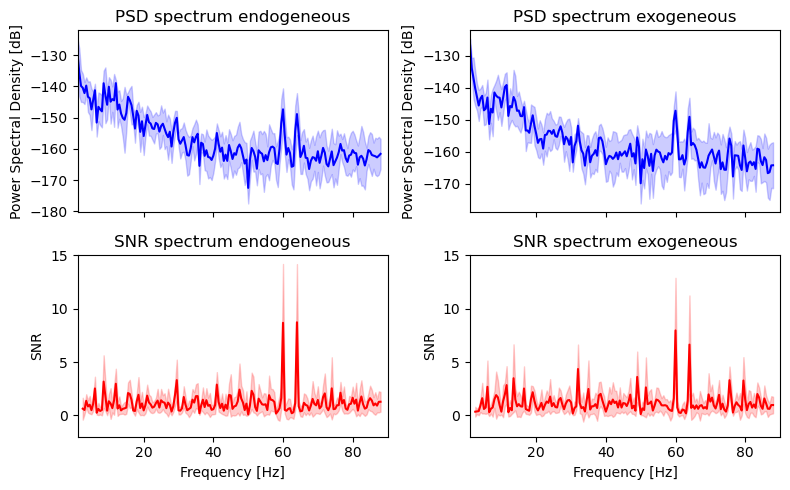

In [6]:
# Fast Fourier Transform
# adapted from https://mne.tools/dev/auto_tutorials/time-freq/50_ssvep.html

sfreq = epochs.info["sfreq"]
tmin = 0 # Search in window starting from cue (when SSVEP is expected)
tmax = 2
fmin = 1.0
fmax = 90

# Spectrum of the signal averaged over trials
spectrum_endo = epochs_endo.copy().average().compute_psd(
    "welch",
    n_fft=int(sfreq * (tmax - tmin)),
    n_overlap=0,
    n_per_seg=None,
    tmin=tmin,
    tmax=tmax,
    fmin=fmin,
    fmax=fmax,
    window="hamming",
    verbose=False,
)
psds_endo, freqs_psd = spectrum_endo.get_data(return_freqs=True)
spectrum_endo = epochs_endo.copy().average().compute_psd(
    "welch",
    n_fft=int(sfreq * (tmax - tmin)),
    n_overlap=0,
    n_per_seg=None,
    tmin=tmin,
    tmax=tmax,
    fmin=fmin,
    fmax=fmax,
    window="hamming",
    verbose=False,
)
psds_endo, freqs_psd = spectrum_endo.get_data(return_freqs=True)


# Get bins to exlude from regularization (close neighbors ±0.5Hz)  
bin_size = np.diff(freqs_psd)[0]
skip_nei = int((0.5 - bin_size/2)//bin_size) 

# Get bins to include in regularization (neighbors within +/- 2-0.5Hz)
used_nei = int((2 - bin_size/2) // bin_size)  # Total bins within ±2 Hz
used_nei = used_nei - skip_nei # Bins within (0.5 Hz, 2 Hz]

snrs_endo = snr_spectrum(psds_endo, noise_n_neighbor_freqs=used_nei, noise_skip_neighbor_freqs = skip_nei)
snrs_endo = snr_spectrum(psds_endo, noise_n_neighbor_freqs=used_nei, noise_skip_neighbor_freqs = skip_nei)

fig, axes = plt.subplots(2, 2, sharex="all", sharey="none", figsize=(8, 5))
freq_range = range(
    np.where(np.floor(freqs_psd) == 1.0)[0][0], np.where(np.ceil(freqs_psd) == fmax - 1)[0][0]
)

psds_plot = 10 * np.log10(psds_endo)
psds_mean = psds_plot.mean(axis=(0))[freq_range]
psds_std = psds_plot.std(axis=(0))[freq_range]
axes[0,0].plot(freqs_psd[freq_range], psds_mean, color="b")
axes[0,0].fill_between(
    freqs_psd[freq_range], psds_mean - psds_std, psds_mean + psds_std, color="b", alpha=0.2
)
axes[0,0].set(title="PSD spectrum endogeneous", ylabel="Power Spectral Density [dB]")
psds_plot = 10 * np.log10(psds_endo)
psds_mean = psds_plot.mean(axis=(0))[freq_range]
psds_std = psds_plot.std(axis=(0))[freq_range]
axes[0,1].plot(freqs_psd[freq_range], psds_mean, color="b")
axes[0,1].fill_between(
    freqs_psd[freq_range], psds_mean - psds_std, psds_mean + psds_std, color="b", alpha=0.2
)
axes[0,1].set(title="PSD spectrum endogeneous", ylabel="Power Spectral Density [dB]")

# SNR spectrum
snr_mean = snrs_endo.mean(axis=(0))[freq_range]
snr_std = snrs_endo.std(axis=(0))[freq_range]

axes[1,0].plot(freqs_psd[freq_range], snr_mean, color="r")
axes[1,0].fill_between(
    freqs_psd[freq_range], snr_mean - snr_std, snr_mean + snr_std, color="r", alpha=0.2
)
axes[1,0].set(
    title="SNR spectrum endogeneous",
    xlabel="Frequency [Hz]",
    ylabel="SNR",
    ylim=[-2, 15],
    xlim=[fmin, fmax],
)
snr_mean = snrs_endo.mean(axis=(0))[freq_range]
snr_std = snrs_endo.std(axis=(0))[freq_range]

axes[1,1].plot(freqs_psd[freq_range], snr_mean, color="r")
axes[1,1].fill_between(
    freqs_psd[freq_range], snr_mean - snr_std, snr_mean + snr_std, color="r", alpha=0.2
)
axes[1,1].set(
    title="SNR spectrum endogeneous",
    xlabel="Frequency [Hz]",
    ylabel="SNR",
    ylim=[-2, 15],
    xlim=[fmin, fmax],
)
plt.tight_layout()
fig.show()

# Extract SNR values at the stimulation frequency
stim_freq1 = 60
stim_freq2 = 64

# find index of frequency bin closest to stimulation frequency
i_bin_1 = np.argmin(abs(freqs_psd - stim_freq1))
i_bin_2 = np.argmin(abs(freqs_psd - stim_freq2))

# Apply the subset
snrs_target1_endo = snrs_endo[:, i_bin_1]
snrs_target2_endo = snrs_endo[:, i_bin_2]
print(f'SNR at {stim_freq1}Hz in endogenous condition: {snrs_target1_endo.mean()}')
print(f'SNR at {stim_freq2}Hz in endogenous: {snrs_target2_endo.mean()}')
snrs_target1_endo = snrs_endo[:, i_bin_1]
snrs_target2_endo = snrs_endo[:, i_bin_2]
print(f'SNR at {stim_freq1}Hz in endogenous condition: {snrs_target1_endo.mean()}')
print(f'SNR at {stim_freq2}Hz in endogenous: {snrs_target2_endo.mean()}')


## 1.2 Topography of the SNR

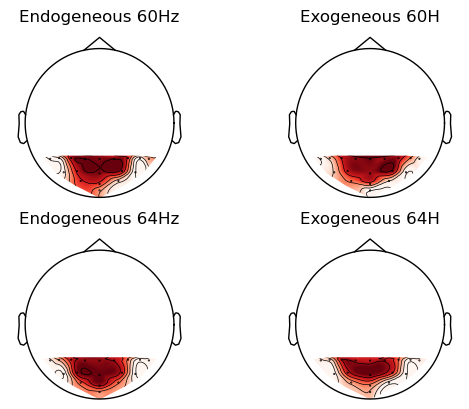

Channels with highest SNR for 60Hz endo ['P1' 'P2' 'POz' 'Pz' 'PO4' 'P3']
Channels with highest SNR for 64Hz endo['PO4' 'Pz' 'P1' 'POz' 'P4' 'P2']
Channels with highest SNR for 60Hz exo ['POz' 'PO3' 'Oz' 'Pz' 'P1' 'P2']
Channels with highest SNR for 64Hz exo ['POz' 'P3' 'P2' 'P1' 'PO3' 'Pz']


In [7]:
# plot SNR topography
fig, ax = plt.subplots(2,2)
mne.viz.plot_topomap(snrs_target1_endo, epochs.info, vlim=(1, None), axes=ax[0,0], show=False, extrapolate='local')
mne.viz.plot_topomap(snrs_target2_endo, epochs.info, vlim=(1, None), axes=ax[0,1], show=False, extrapolate='local')
mne.viz.plot_topomap(snrs_target1_endo, epochs.info, vlim=(1, None), axes=ax[1,0], show=False, extrapolate='local')
mne.viz.plot_topomap(snrs_target2_endo, epochs.info, vlim=(1, None), axes=ax[1,1], show=False, extrapolate='local')
ax[0,0].set_title('Endogeneous 60Hz')
ax[0,1].set_title('endogeneous 60H')
ax[1,0].set_title('Endogeneous 64Hz')
ax[1,1].set_title('endogeneous 64H')
plt.show()

# Channels with the highest SNR 
print(f'Channels with highest SNR for 60Hz endo {np.array(epochs.info['ch_names'])[np.argsort(snrs_target1_endo)[::-1]][:6]}')
print(f'Channels with highest SNR for 64Hz endo{np.array(epochs.info['ch_names'])[np.argsort(snrs_target2_endo)[::-1]][:6]}')
print(f'Channels with highest SNR for 60Hz endo {np.array(epochs.info['ch_names'])[np.argsort(snrs_target1_endo)[::-1]][:6]}')
print(f'Channels with highest SNR for 64Hz endo {np.array(epochs.info['ch_names'])[np.argsort(snrs_target2_endo)[::-1]][:6]}')
#select electrodes from 60 as the top electrodes are parietal and occipital
SNR_best_electrodes_60_endo = np.array(epochs.info['ch_names'])[np.argsort(snrs_target1_endo)[::-1]][:6]
SNR_best_electrodes_64_endo = np.array(epochs.info['ch_names'])[np.argsort(snrs_target2_endo)[::-1]][:6]
SNR_best_electrodes_60_endo = np.array(epochs.info['ch_names'])[np.argsort(snrs_target1_endo)[::-1]][:6]
SNR_best_electrodes_64_endo = np.array(epochs.info['ch_names'])[np.argsort(snrs_target2_endo)[::-1]][:6]

## 1.3 Time frequency analysis of coherence by electrode
Coherence is studied in the time window between trial start and onset of the stimuli (the post stimuli window is likely contaminated by attentional catching due to their onset).

In [8]:
# # time window from -1 sec to 1 sec relative to cue
# tmin, tmax = -1, 1
# # Define range of frequencies of interest
# freqs = np.arange(55, 75, step = 0.5)

### Magnitude squared coherence with Hilbert transform

In [9]:
# def coherence_kabir(signalX, pick, freq_of_interest):

#     #get info from EEG
#     min_time = signalX.times[0]
#     max_time = signalX.times[-1]
#     sampling_rate = signalX.info['sfreq']
    
#     # Band-pass EEG (+/-1.9Hz) and apply hilbert
#     signalX = signalX.copy().pick(pick).filter(l_freq=freq_of_interest - 1.9, h_freq=freq_of_interest + 1.9,
#         method='iir', iir_params=dict(order=4, ftype='butter'), phase='zero', fir_window='hamming', verbose = False)
#     #filter(l_freq = freq_of_interest - 1.9, h_freq = freq_of_interest + 1.9, verbose=True)
    
#     signalX = np.squeeze(signalX.get_data(copy=False)).T
#     signalXh =  scipy.signal.hilbert(signalX, axis=1)
#     n = signalXh.shape[1]  # number of trials

#     #Create sine wave
#     t = np.linspace(min_time, max_time, int(sampling_rate * (np.abs(min_time) + max_time))+1, endpoint=False)
#     signalY = np.sin(2 * np.pi * freq_of_interest * t)
#     signalY = np.tile(signalY, (n,1)).T #repeat over trials
#     # Hilbert transform
#     signalYh = scipy.signal.hilbert(signalY.T, axis=1)

#     # Magnitude
#     mX = np.abs(signalXh).T
#     mY = np.abs(signalYh)

#     # Phase difference
#     phase_diff = np.angle(signalXh).T - np.angle(signalYh)

#     coh = np.zeros(signalY.shape[0])
#     for t in range(signalY.shape[0]):
#         num = ((np.abs(np.sum(mX[:, t] * mY[:, t] * np.exp(1j * phase_diff[:, t])) / n)) ** 2)
#         denom = (np.sum((mX[:, t]**2) * (mY[:, t]**2)) / n)
#         coh[t] = num/denom
        
#     return coh

# # time window from -1 sec to 1 sec relative to cue
# tmin, tmax = -1, 1
# # Define range of frequencies of interest
# freqs = np.arange(55, 75, step = 0.5)

# channels = epochs_endo.info['ch_names']

# epochs_endo_cropped = epochs_endo.copy().crop(tmin, tmax)

# coherence_mat = np.zeros((len(channels), freqs.size, len(epochs_endo_cropped.times)))

# for e, channel in enumerate(channels):
#     for i, freq in enumerate(freqs):
#         coherence_mat[e,i,:] = coherence_kabir(epochs_endo_cropped, [channel], freq)

# coherence_hilbert = mne.time_frequency.EpochsTFRArray(epochs_endo_cropped.info, np.array([coherence_mat]), epochs_endo_cropped.times, freqs)

# # Baseline (-1 to 0s) correction
# coherence_hilbert = coherence_hilbert.apply_baseline(baseline=(tmin, 0))

# fig, axes = plt.subplots(3, 6, figsize=(18, 6))  
# axes = axes.flatten() 

# # Plot each channel
# for e, (channel, ax) in enumerate(zip(channels, axes)):
#     coherence_hilbert.plot(
#         picks=[channel],
#         baseline= None,
#         axes=ax,
#         colorbar=False,
#         show=False 
#     )
#     ax.set_title(channel)  

# plt.tight_layout()
# plt.show()



# # Channels with the highest coherence with the cued frequency
# print(f'From best to 5th \nChannels with the highest coherence with 60:{np.array(epochs.info['ch_names'])[np.argsort(np.squeeze(coherence_mat[:,np.where(freqs == 60),:].max(axis = -1)))[::-1]][:6]} \
#                         \nChannels with the highest coherence with 64:{np.array(epochs.info['ch_names'])[np.argsort(np.squeeze(coherence_mat[:,np.where(freqs == 64),:].max(axis = -1)))[::-1]][:6]}')
# best_electrodes_coherence_60 = np.array(epochs.info['ch_names'])[np.argsort(np.squeeze(coherence_mat[:,np.where(freqs == 60),:].max(axis = -1)))[::-1]][:6]
# best_electrodes_coherence_64 = np.array(epochs.info['ch_names'])[np.argsort(np.squeeze(coherence_mat[:,np.where(freqs == 64),:].max(axis = -1)))[::-1]][:6]

### Inter-trial coherence with stockwell estimation

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:   20.9s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:   20.5s


Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied


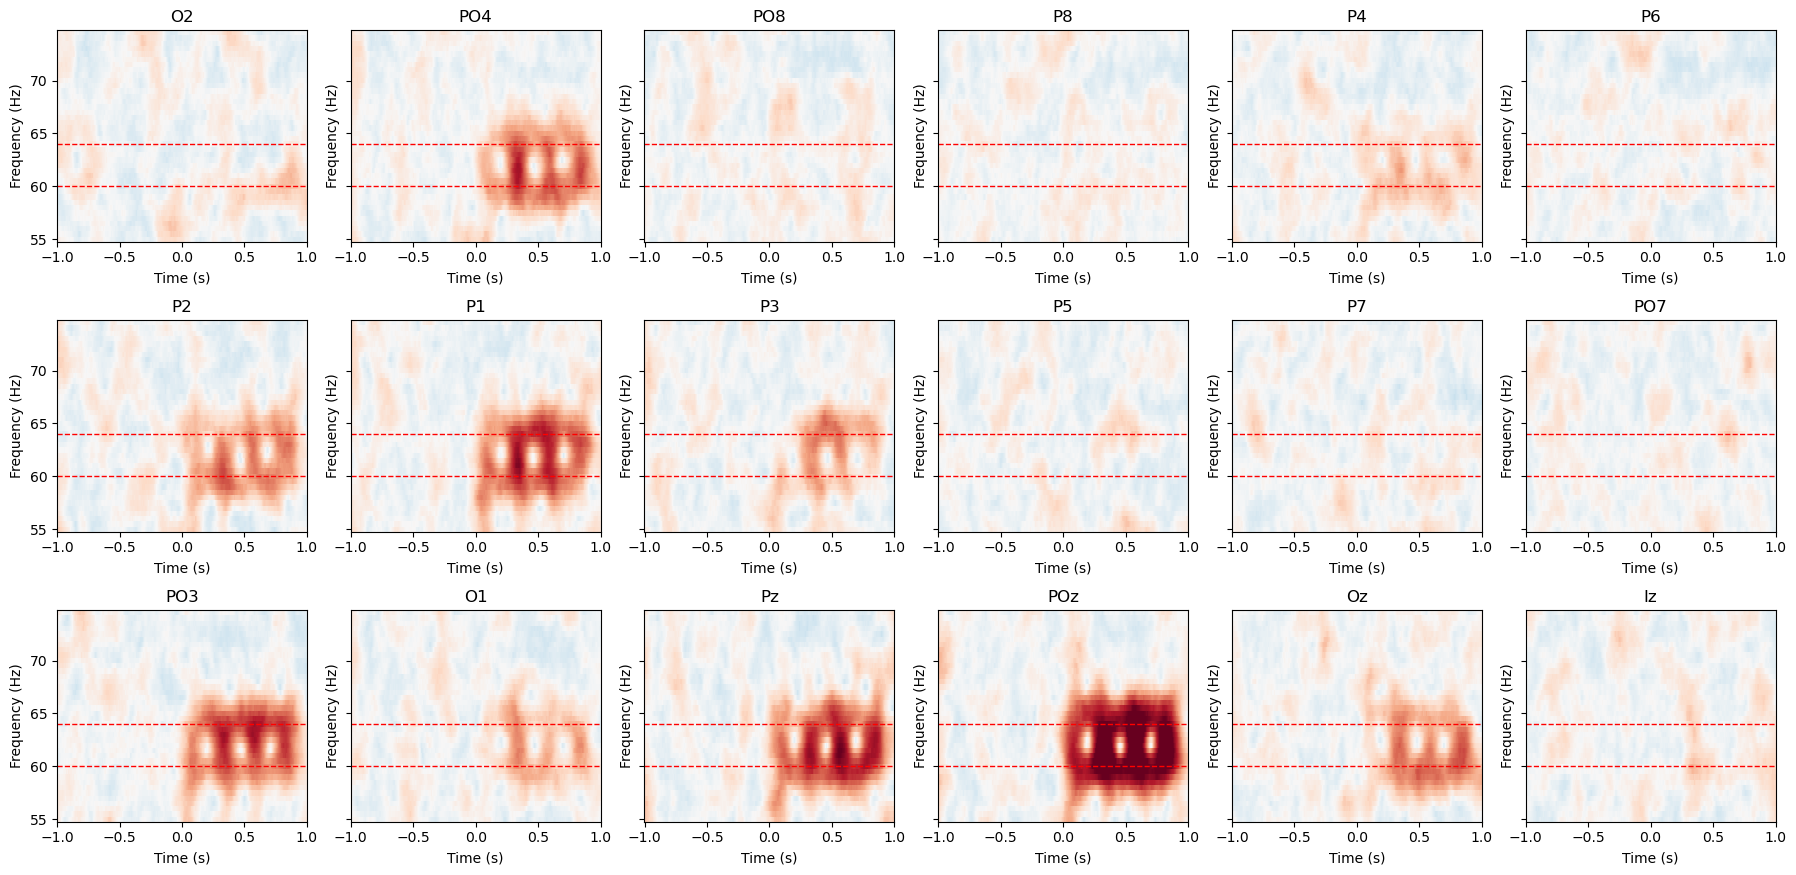

No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied


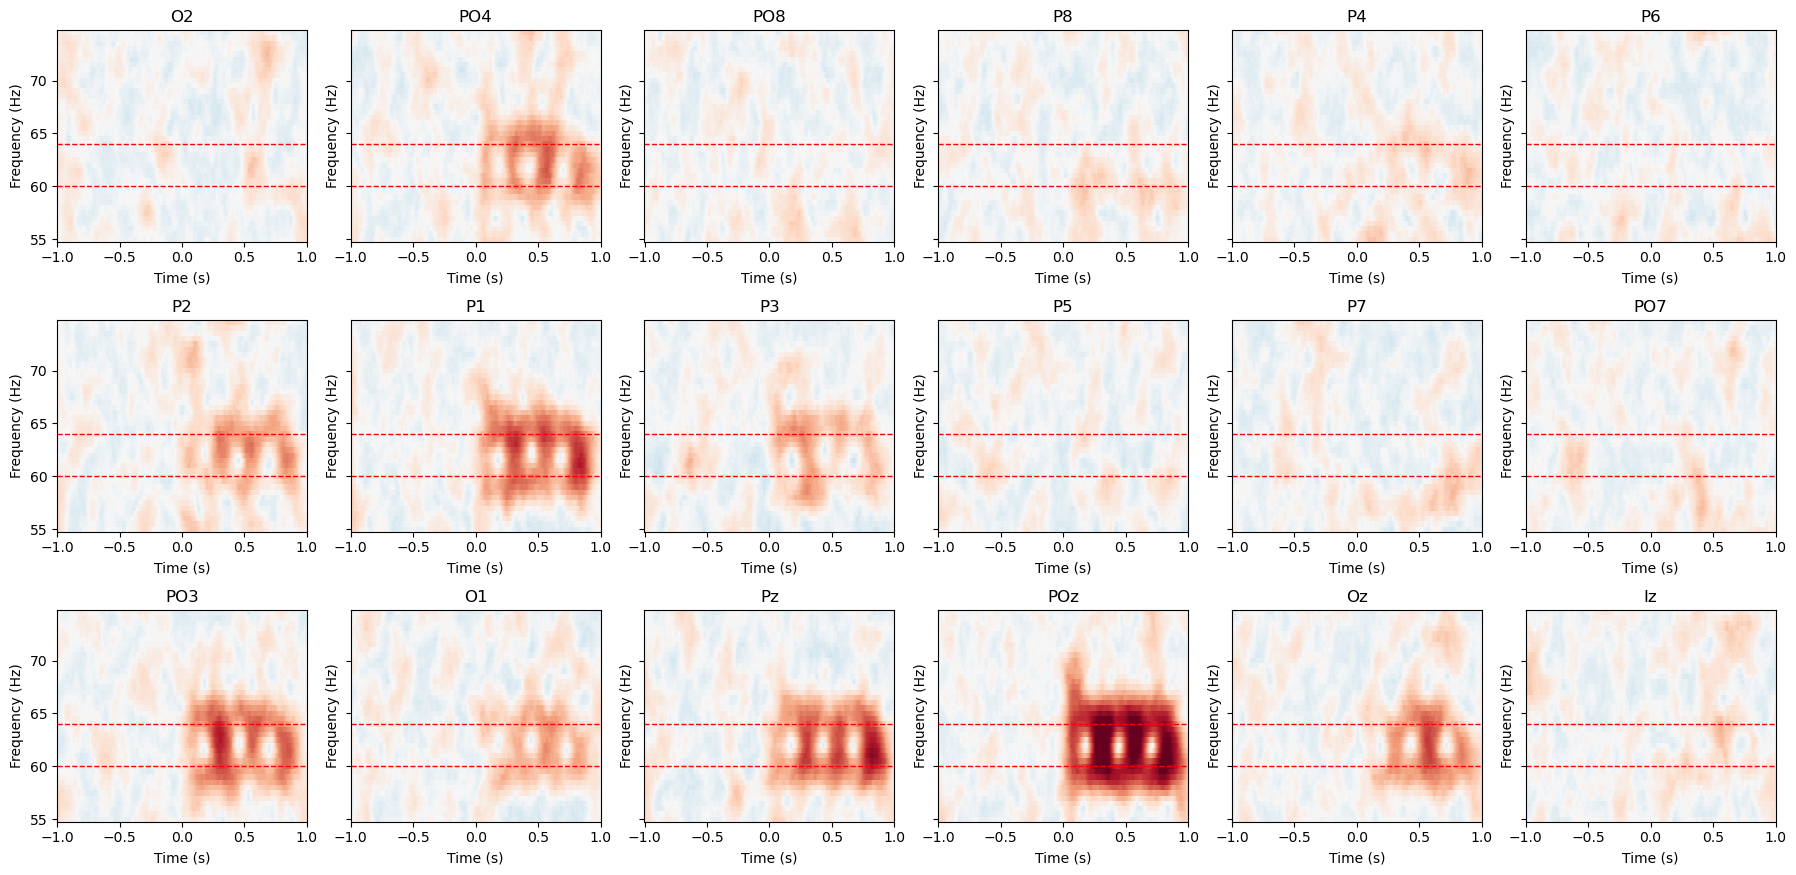

In [10]:
# n_cylce: trade-off temporal vs frequency resolution (is how many cycles of the frequency to include in the Gaussian envelope). 
# Frequency resolution is emphasized.

# time window from -1 sec to 1 sec relative to cue
tmin, tmax = -1, 1
# Define range of frequencies of interest
freqs = np.arange(55, 75, step = 0.5)

_, itc_endo = epochs_endo.copy().crop(tmin, tmax).compute_tfr(
    method="morlet", freqs=freqs, n_cycles=freqs/2,return_itc=True, average=True
)
_, itc_endo = epochs_endo.copy().crop(tmin, tmax).compute_tfr(
    method="morlet", freqs=freqs, n_cycles=freqs/2,return_itc=True, average=True
)

# Baseline (-1 to 0s) correction
itc_endo = itc_endo.apply_baseline(baseline=(tmin, 0))
itc_endo = itc_endo.apply_baseline(baseline=(tmin, 0))

fig, axes = plt.subplots(3, 6, figsize=(18, 9), sharey = True) 
axes = axes.flatten() 

channels = epochs.info['ch_names']

# Plot each electrode
for e, (channel, ax) in enumerate(zip(channels, axes)):
    itc_endo.plot(
        picks=[channel],
        baseline=None,
        vlim=(-.4, .4),
        axes=ax,
        colorbar=False,
        show=False 
    )
    ax.set_title(channel) 
    ax.axhline(y=60, color='r', linestyle='--', linewidth=1)
    ax.axhline(y=64, color='r', linestyle='--', linewidth=1)
    
plt.tight_layout()
plt.show()
fig, axes = plt.subplots(3, 6, figsize=(18, 9), sharey = True) 
axes = axes.flatten() 

channels = epochs.info['ch_names']

# Plot each electrode
for e, (channel, ax) in enumerate(zip(channels, axes)):
    itc_endo.plot(
        picks=[channel],
        baseline=None,
        vlim=(-.4, .4),
        axes=ax,
        colorbar=False,
        show=False 
    )
    ax.set_title(channel) 
    ax.axhline(y=60, color='r', linestyle='--', linewidth=1)
    ax.axhline(y=64, color='r', linestyle='--', linewidth=1)
    
plt.tight_layout()
plt.show()

In [11]:
# Check whether the expected frequencies are indeed the highest
itc_arr, frex_idx = itc_endo.get_data(return_freqs=True)
print(f'Frequencies in endogeneous with the maximum coherence in descending order : {frex_idx[itc_arr.mean(axis=(0,2)).argsort()[::-1]][:4]}')
print(f'From best to 6th \nChannels with the highest coherence with 64 in endo:{np.array(epochs.info['ch_names'])[np.argsort(np.squeeze(itc_arr[:,np.where(frex_idx==60),:].max(axis = -1)))[::-1]][:6]} \
                        \nChannels with the highest coherence with 60 in endo:{np.array(epochs.info['ch_names'])[np.argsort(np.squeeze(itc_arr[:,np.where(frex_idx==64),:].max(axis = -1)))[::-1]][:6]}')
best_electrodes_coherence_stockwell_60_endo = np.array(epochs.info['ch_names'])[np.argsort(np.squeeze(itc_arr[:,np.where(frex_idx==60),:].max(axis = -1)))[::-1]][:6]
best_electrodes_coherence_stockwell_64_endo = np.array(epochs.info['ch_names'])[np.argsort(np.squeeze(itc_arr[:,np.where(frex_idx==64),:].max(axis = -1)))[::-1]][:6]

itc_arr, frex_idx = itc_endo.get_data(return_freqs=True)
print(f'Frequencies in endogeneous with the maximum coherence in descending order : {frex_idx[itc_arr.mean(axis=(0,2)).argsort()[::-1]][:4]}')
print(f'From best to 6th \nChannels with the highest coherence with 64 in endo:{np.array(epochs.info['ch_names'])[np.argsort(np.squeeze(itc_arr[:,np.where(frex_idx==60),:].max(axis = -1)))[::-1]][:6]} \
                        \nChannels with the highest coherence with 60 in enxxo:{np.array(epochs.info['ch_names'])[np.argsort(np.squeeze(itc_arr[:,np.where(frex_idx==64),:].max(axis = -1)))[::-1]][:6]}')
best_electrodes_coherence_stockwell_60_endo = np.array(epochs.info['ch_names'])[np.argsort(np.squeeze(itc_arr[:,np.where(frex_idx==60),:].max(axis = -1)))[::-1]][:6]
best_electrodes_coherence_stockwell_64_endo = np.array(epochs.info['ch_names'])[np.argsort(np.squeeze(itc_arr[:,np.where(frex_idx==64),:].max(axis = -1)))[::-1]][:6]

Frequencies in endogeneous with the maximum coherence in descending order : [60.  60.5 59.5 64. ]
From best to 6th 
Channels with the highest coherence with 64 in endo:['POz' 'Pz' 'P1' 'PO4' 'PO3' 'P2']                         
Channels with the highest coherence with 60 in endo:['POz' 'PO3' 'P1' 'Pz' 'PO4' 'P3']
Frequencies in exogeneous with the maximum coherence in descending order : [60.  59.5 64.  63.5]
From best to 6th 
Channels with the highest coherence with 64 in exo:['POz' 'Pz' 'PO3' 'P1' 'Oz' 'PO4']                         
Channels with the highest coherence with 60 in enxxo:['POz' 'PO3' 'P1' 'Pz' 'Oz' 'PO4']


## 1.4 Select electrodes based on previous analysis

In [12]:
print(f'Top 6 electrodes for SNR 60 endo {SNR_best_electrodes_60_endo}')
print(f'Top 6 electrodes for SNR 64 endo {SNR_best_electrodes_64_endo}')
print(f'Top 6 electrodes for SNR 60 endo {SNR_best_electrodes_60_endo}')
print(f'Top 6 electrodes for SNR 64 endo {SNR_best_electrodes_64_endo}')
# print(f'Top 6 electrodes for Coherence 60 {best_electrodes_coherence_60}')
# print(f'Top 6 electrodes for Coherence 64 {best_electrodes_coherence_64}')
print(f'Top 6 electrodes for ITC stockwell 60 endo {best_electrodes_coherence_stockwell_60_endo}')
print(f'Top 6 electrodes for ITC stockwell 64 endo {best_electrodes_coherence_stockwell_64_endo}')

print(f'Top 6 electrodes for ITC stockwell 60 endo {best_electrodes_coherence_stockwell_60_endo}')
print(f'Top 6 electrodes for ITC stockwell 64 endo {best_electrodes_coherence_stockwell_64_endo}')

Top 6 electrodes for SNR 60 endo ['P1' 'P2' 'POz' 'Pz' 'PO4' 'P3']
Top 6 electrodes for SNR 64 endo ['PO4' 'Pz' 'P1' 'POz' 'P4' 'P2']
Top 6 electrodes for SNR 60 exo ['POz' 'PO3' 'Oz' 'Pz' 'P1' 'P2']
Top 6 electrodes for SNR 64 exo ['POz' 'P3' 'P2' 'P1' 'PO3' 'Pz']
Top 6 electrodes for ITC stockwell 60 endo ['POz' 'Pz' 'P1' 'PO4' 'PO3' 'P2']
Top 6 electrodes for ITC stockwell 64 endo ['POz' 'PO3' 'P1' 'Pz' 'PO4' 'P3']
Top 6 electrodes for ITC stockwell 60 exo ['POz' 'Pz' 'PO3' 'P1' 'Oz' 'PO4']
Top 6 electrodes for ITC stockwell 64 exo ['POz' 'PO3' 'P1' 'Pz' 'Oz' 'PO4']


In [13]:
# Select top 6 electrodes that are the most often the best according to SNR, IT coherence and MS coherence
all_electrodes = (list(SNR_best_electrodes_60_endo) + 
                  list(SNR_best_electrodes_64_endo) + 
                  list(SNR_best_electrodes_60_endo) + 
                  list(SNR_best_electrodes_64_endo) + 
                  # list(best_electrodes_coherence_60) + 
                  # list(best_electrodes_coherence_64) + 
                  list(best_electrodes_coherence_stockwell_60_endo) + 
                  list(best_electrodes_coherence_stockwell_64_endo) + 
                  list(best_electrodes_coherence_stockwell_60_endo) + 
                  list(best_electrodes_coherence_stockwell_64_endo))

# Count the occurrences of each electrode
electrode_counts = Counter(all_electrodes)

best_electrodes = [electrode for electrode, count in electrode_counts.most_common(6)]

print(f'selected electrodes: {best_electrodes}')

selected electrodes: ['P1', 'POz', 'Pz', 'PO4', 'PO3', 'P2']


# 2 - Testing for an attentional effect
### Comparing SNR across cued conditions

In [14]:
queries = ["cued_tag == 60 & attention_type_block==0", "cued_tag == 64 & attention_type_block==0",
          "cued_tag == 60 & attention_type_block==1", "cued_tag == 64 & attention_type_block==1"]
vals = {}
stim_freq1 = 60
stim_freq2 = 64

sfreq = epochs_endo.info['sfreq']
tmin = 0 # Search in window starting from cue (when SSVEP is expected)
tmax = 2
fmin = 1.0
fmax = 90.0

for query in queries:
    # Spectrum averaged over all trials
    spectrum = epochs[query].copy().pick(best_electrodes).compute_psd(
        "welch",
        n_fft=int(sfreq * (tmax - tmin)),
        n_overlap=0,
        n_per_seg=None,
        tmin=tmin,
        tmax=tmax,
        fmin=fmin,
        fmax=fmax,
        window="hamming",
        verbose=False,
    )
    psds, freqs_psd = spectrum.get_data(return_freqs=True)

    # find index of frequency bin closest to stimulation frequency
    i_bin_1 = np.argmin(abs(freqs_psd - stim_freq1))
    i_bin_2 = np.argmin(abs(freqs_psd - stim_freq2))
    
    # Apply the subset
    vals[str(int(stim_freq1))+query] = copy.deepcopy(np.mean(psds,axis=0)[:, i_bin_1])
    vals[str(int(stim_freq2))+query] = copy.deepcopy(np.mean(psds,axis=0)[:, i_bin_2])


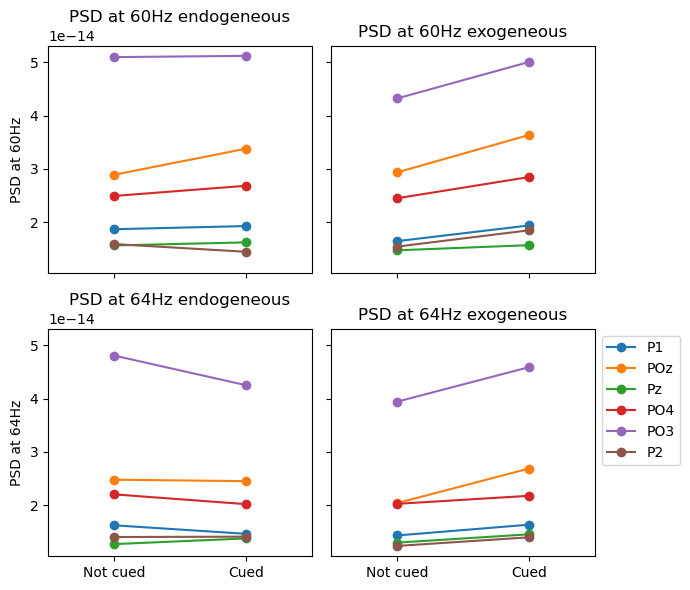

In [15]:
fig, ax = plt.subplots(2,2, figsize=(7,6), sharex=True, sharey=True)
for e, elec in enumerate(best_electrodes):
    ax[0,0].plot([0,1], [vals['60cued_tag == 64 & attention_type_block==0'][e], vals['60cued_tag == 60 & attention_type_block==0'][e]], 'o-', label=elec)
    ax[1,0].plot([0,1], [vals['64cued_tag == 60 & attention_type_block==0'][e], vals['64cued_tag == 64 & attention_type_block==0'][e]], 'o-', label=elec)
    ax[0,1].plot([0,1], [vals['60cued_tag == 64 & attention_type_block==1'][e], vals['60cued_tag == 60 & attention_type_block==1'][e]], 'o-', label=elec)
    ax[1,1].plot([0,1], [vals['64cued_tag == 60 & attention_type_block==1'][e], vals['64cued_tag == 64 & attention_type_block==1'][e]], 'o-', label=elec)

ax[0,0].set_title('PSD at 60Hz endogeneous')
ax[0,1].set_title('PSD at 60Hz endogeneous')
ax[1,0].set_title('PSD at 64Hz endogeneous')
ax[1,1].set_title('PSD at 64Hz endogeneous')
ax[0,0].set_ylabel('PSD at 60Hz')
ax[1,0].set_ylabel('PSD at 64Hz')
ax[1,0].set_xticks([0,1], ['Not cued', 'Cued'])
ax[1,1].set_xticks([0,1], ['Not cued', 'Cued'])
ax[1,1].set_xlim(-.5, 1.5)
plt.legend(bbox_to_anchor=(1,1))
plt.tight_layout()
plt.show()

In [16]:
# Normalize the frequency amplitudes as in Adamian & Andersen, 2024
npsd56 = frequency_rescaling(np.vstack([vals['60cued_tag == 60 & attention_type_block==0'],\
                                        vals['60cued_tag == 64 & attention_type_block==0'],
                                        vals['60cued_tag == 60 & attention_type_block==1'],
                                        vals['60cued_tag == 64 & attention_type_block==1'],]).T)
npsd60 = frequency_rescaling(np.vstack([vals['64cued_tag == 64 & attention_type_block==0'],\
                                        vals['64cued_tag == 60 & attention_type_block==0'],
                                        vals['64cued_tag == 64 & attention_type_block==1'],
                                        vals['64cued_tag == 60 & attention_type_block==1'],]).T)
npsds = np.concatenate([npsd56,npsd60])

# Average over electrodes
# npsds = npsds.mean(axis=0)
# np.save('files/B1_normalizes_psds.npy', npsds)

### Comparing inter-trial coherence across cued conditions

In [17]:
# time window from -1 sec to 1 sec relative to cue
tmin, tmax = -1, 1

# Get inter-trial coherence with 60 and 64Hz by cued frequency 
freqs6064 = np.array([60, 64])
_, itc_64_endo = epochs_endo['cued_tag == 64'].copy().crop(tmin, tmax).compute_tfr(
    method="morlet", freqs=freqs6064, n_cycles=freqs6064/2,return_itc=True, average=True
)

_, itc_60_endo = epochs_endo['cued_tag == 60'].copy().crop(tmin, tmax).compute_tfr(
    method="morlet", freqs=freqs6064, n_cycles=freqs6064/2,return_itc=True, average=True
)
_, itc_64_endo = epochs_endo['cued_tag == 64'].copy().crop(tmin, tmax).compute_tfr(
    method="morlet", freqs=freqs6064, n_cycles=freqs6064/2,return_itc=True, average=True
)

_, itc_60_endo = epochs_endo['cued_tag == 60'].copy().crop(tmin, tmax).compute_tfr(
    method="morlet", freqs=freqs6064, n_cycles=freqs6064/2,return_itc=True, average=True
)

elec_idx = np.where(np.isin(epochs.info['ch_names'], best_electrodes))[0]

coherence = {}
itc_64_arr, times_coh, freqs_idx = itc_64_endo.get_data(return_freqs = True, return_times = True)
itc_60_arr = itc_60_endo.get_data()
coherence['with64_for64cued_endo'] = itc_64_arr[elec_idx,1,:]
coherence['with60_for64cued_endo'] = itc_64_arr[elec_idx,0,:]
coherence['with64_for60cued_endo'] = itc_60_arr[elec_idx,1,:]
coherence['with60_for60cued_endo'] = itc_60_arr[elec_idx,0,:]
itc_64_arr, times_coh, freqs_idx = itc_64_endo.get_data(return_freqs = True, return_times = True)
itc_60_arr = itc_60_endo.get_data()
coherence['with64_for64cued_endo'] = itc_64_arr[elec_idx,1,:]
coherence['with60_for64cued_endo'] = itc_64_arr[elec_idx,0,:]
coherence['with64_for60cued_endo'] = itc_60_arr[elec_idx,1,:]
coherence['with60_for60cued_endo'] = itc_60_arr[elec_idx,0,:]

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.6s


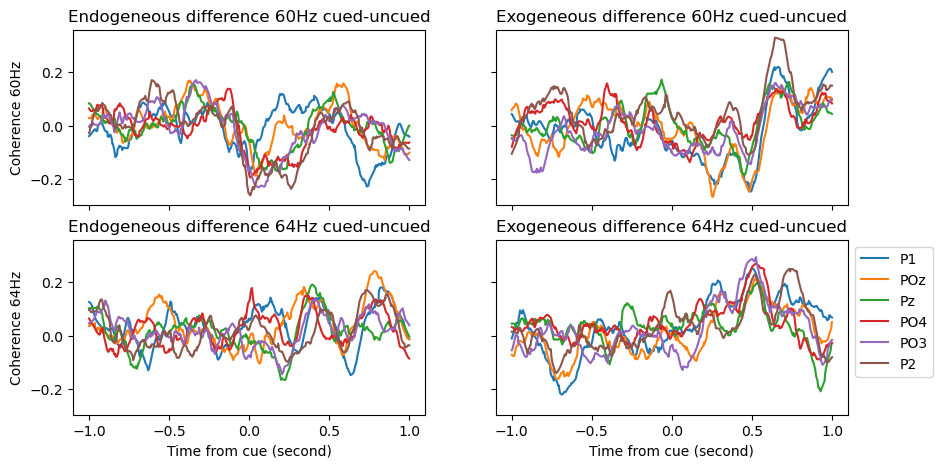

In [18]:
fig, ax = plt.subplots(2,2, sharex=True, sharey=True, figsize=(10,5))
ax[0,0].plot(times_coh, coherence['with60_for60cued_endo'].T - coherence['with60_for64cued_endo'].T, label = best_electrodes)
ax[0,0].set_ylabel('Coherence 60Hz')
ax[0,0].set_title('Endogeneous difference 60Hz cued-uncued')
ax[1,0].plot(times_coh, coherence['with64_for64cued_endo'].T - coherence['with64_for60cued_endo'].T, label = best_electrodes)
ax[1,0].set_ylabel('Coherence 64Hz')
ax[1,0].set_title('Endogeneous difference 64Hz cued-uncued')
ax[0,1].plot(times_coh, coherence['with60_for60cued_endo'].T - coherence['with60_for64cued_endo'].T, label = best_electrodes)
ax[0,1].set_title('endogeneous difference 60Hz cued-uncued')
ax[1,1].plot(times_coh, coherence['with64_for64cued_endo'].T - coherence['with64_for60cued_endo'].T, label = best_electrodes)
ax[1,1].set_title('endogeneous difference 64Hz cued-uncued')

# for axi in ax.flatten():
#     axi.vlines(0, -.4, .4, color='black')

plt.legend(bbox_to_anchor=(1,1))
ax[1,0].set_xlabel('Time from cue (second)')
ax[1,1].set_xlabel('Time from cue (second)')
plt.show()


In [19]:
# Export for group analysis

def pd_coh(coherence_dic, cued, coh_with, condition):
    coherence = pd.DataFrame(coherence_dic[f'with{coh_with}_for{cued}cued_{condition}'])
    coherence['channel'] = best_electrodes
    coherence['cued'] = cued
    coherence['coh_with'] = coh_with
    coherence['condition'] = condition
    coherence = coherence.melt(id_vars=['channel','cued','coh_with','condition'])
    coherence['time'] = coherence['variable']*(1/epochs_endo.info['sfreq']) + tmin
    return coherence

coh64_cue64_endo = pd_coh(coherence, 64, 64, 'endo')
coh64_cue60_endo = pd_coh(coherence, 60, 64, 'endo')
coh60_cue64_endo = pd_coh(coherence, 64, 60, 'endo')
coh60_cue60_endo = pd_coh(coherence, 60, 60, 'endo')
coh64_cue64_endo = pd_coh(coherence, 64, 64, 'endo')
coh64_cue60_endo = pd_coh(coherence, 60, 64, 'endo')
coh60_cue64_endo = pd_coh(coherence, 64, 60, 'endo')
coh60_cue60_endo = pd_coh(coherence, 60, 60, 'endo')

ITcoh_B1 = pd.concat([coh60_cue60_endo, coh60_cue64_endo, coh64_cue60_endo, coh64_cue64_endo,
                     coh60_cue60_endo, coh60_cue64_endo, coh64_cue60_endo, coh64_cue64_endo])
ITcoh_B1.columns = ['channel', 'cued', 'coh_with', 'condition', 'timepoint', 'ITcoherence', 'time']
ITcoh_B1.to_csv('files/ITcoh_B1.csv',index=False)

### Comparing MS coherence across cued conditions

In [20]:
# # time window from -1 sec to 1 sec relative to cue
# tmin, tmax = -1, 1
# # Define range of frequencies of interest
# freqs = np.array([60, 64])

# epochs_endo_cropped = epochs_endo['cued_tag == 64'].copy().pick(best_electrodes).crop(tmin, tmax)
# coherence_mat = np.zeros((len(best_electrodes), freqs.size, len(epochs_endo_cropped.times)))
# for e, channel in enumerate(best_electrodes):
#     for i, freq in enumerate(freqs):
#         coherence_mat[e,i,:] = coherence_kabir(epochs_endo_cropped, [channel], freq)
# coherence_hilbert_64 = mne.time_frequency.EpochsTFRArray(epochs_endo_cropped.info, np.array([coherence_mat]), epochs_endo_cropped.times, freqs)

# epochs_endo_cropped = epochs_endo['cued_tag == 60'].copy().pick(best_electrodes).crop(tmin, tmax)
# coherence_mat = np.zeros((len(best_electrodes), freqs.size, len(epochs_endo_cropped.times)))
# for e, channel in enumerate(best_electrodes):
#     for i, freq in enumerate(freqs):
#         coherence_mat[e,i,:] = coherence_kabir(epochs_endo_cropped, [channel], freq)
# coherence_hilbert_60 = mne.time_frequency.EpochsTFRArray(epochs_endo_cropped.info, np.array([coherence_mat]), epochs_endo_cropped.times, freqs)

# coherence_hilbert_64, times_coh, freqs_idx = coherence_hilbert_64.get_data(return_freqs = True, return_times = True)
# coherence_hilbert_60 = coherence_hilbert_60.get_data()

In [21]:
# coherence_hilbert = {}
# coherence_hilbert['with64_for64cued'] = np.squeeze(coherence_hilbert_64)[:,1,:]
# coherence_hilbert['with60_for64cued'] = np.squeeze(coherence_hilbert_64)[:,0,:]
# coherence_hilbert['with64_for60cued'] = np.squeeze(coherence_hilbert_60)[:,1,:]
# coherence_hilbert['with60_for60cued'] = np.squeeze(coherence_hilbert_60)[:,0,:]

# plt.plot(times_coh, coherence_hilbert['with64_for64cued'].T - coherence_hilbert['with64_for60cued'].T, label = best_electrodes)
# plt.vlines(0,-0.35,0.3, color = 'black')
# plt.legend()
# plt.title('Coherence with 64Hz when 64 cued - coherence with 64 when 64 not cued')
# plt.xlabel('Time from cue')
# plt.ylabel('Coherence contrast cued/uncued')
# plt.show()

# plt.plot(times_coh, coherence_hilbert['with60_for60cued'].T - coherence_hilbert['with60_for64cued'].T, label = best_electrodes)
# plt.vlines(0,-0.35,0.3, color = 'black')
# plt.legend()
# plt.title('Coherence with 60Hz when 60 cued - coherence with 60 when 60 not cued')
# plt.xlabel('Time from cue')
# plt.ylabel('Coherence contrast cued/uncued')

In [22]:
# # Export for group analysis
# coh64_cue64 = pd_coh(coherence_hilbert, 64, 64)
# coh64_cue60 = pd_coh(coherence_hilbert, 60, 64)
# coh60_cue64 = pd_coh(coherence_hilbert, 64, 60)
# coh60_cue60 = pd_coh(coherence_hilbert, 60, 60)

# MScoh_B1 = pd.concat([coh60_cue60, coh60_cue64, coh64_cue60, coh64_cue64])
# MScoh_B1.columns = ['channel', 'cued', 'coh_with', 'timepoint', 'MScoherence', 'time']
# MScoh_B1.to_csv('files/MScoh_B1.csv',index=False)

# 3 - Predict cued tag with a classifier

In [141]:
# Load eeg epochs again to use all channels
epochs = mne.read_epochs(f'{data_path}{epoch_file}')
epoch_good = [x for x,y in enumerate(epochs.drop_log) if len(y) == 0]
epochs.metadata = pd_info.iloc[epoch_good]

# Remove trials where a target occured
epochs = epochs['targets_binary == 0']

# Crop to after the latest target onset possibility
epochs.crop(-.2, .8)

# Downsample for speed
epochs.resample(200)

epochs_post_erp = epochs.copy().crop(tmin = .25)

Reading /home/lea/Documents/obsidian_notes/masterADS/ads_thesis_RIFT/my_code_expe2/data/B1/preprocessing/B1_EEG_epo.fif ...
    Found the data of interest:
        t =   -1000.00 ...    2000.00 ms
        0 CTF compensation matrices available
Not setting metadata
573 matching events found
No baseline correction applied
0 projection items activated
Adding metadata with 14 columns


In [142]:
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from mne.decoding import SlidingEstimator, cross_val_multiscore

# Data preparation
epochs_post_erp = epochs.copy().crop(tmin=0.25)
epochs_endo = epochs_post_erp['attention_type_block==1'].copy()
epochs_endo = epochs_post_erp['attention_type_block==0'].copy()

# Data and class to predict
X_endo = epochs_endo.copy().get_data(copy=False)
y_endo = epochs_endo.metadata['cued_side']

# Model fitting
clf_endo = make_pipeline(StandardScaler(), LogisticRegression(solver="liblinear"))
time_decod_endo = SlidingEstimator(clf_endo, n_jobs=5, scoring="roc_auc", verbose=True)
scores_endo = cross_val_multiscore(time_decod_endo, X_endo, y_endo, cv=5, n_jobs=5)

# Mean scores across cross-validation splits
scores_endo = np.mean(scores_endo, axis=0)

# Find the best time point
best_time_idx = np.argmax(scores_endo)
best_time = epochs_endo.times[best_time_idx]
print(f"Best time point post-250ms: {best_time} seconds with score: {scores_endo[best_time_idx]}")

# Train the model on the best time point
best_time_data = X_endo[:, :, best_time_idx]
clf_endo_best = make_pipeline(StandardScaler(), LogisticRegression(solver="liblinear"))
clf_endo_best.fit(best_time_data, y_endo)

# Apply the model to the data pre-250ms
epochs_pre_250ms = epochs.copy().crop(tmax=0.25)
X_pre_250ms = epochs_pre_250ms.copy().get_data(copy=False)

# Ensure the feature dimensions are consistent with the best time point
X_pre_250ms_best_time = X_pre_250ms[:, :, best_time_idx]

# Predict the cued side for pre-250ms data
y_pred_pre_250ms = clf_endo_best.predict(X_pre_250ms_best_time)

# Output predictions
print("Predictions for time points before 250ms:", y_pred_pre_250ms)


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
 21%|██        | Fitting SlidingEstimator : 23/110 [00:00<00:00,  317.48it/s]
 32%|███▏      | Fitting SlidingEstimator : 35/110 [00:00<00:00,  327.08it/s]
 46%|████▋     | Fitting SlidingEstimator : 51/110 [00:00<00:00,  359.93it/s]

  0%|          | Fitting SlidingEstimator : 0/110 [00:00<?,       ?it/s]
 56%|█████▋    | Fitting SlidingEstimator : 62/110 [00:00<00:00,  345.77it/s]
 29%|██▉       | Fitting SlidingEstimator : 32/110 [00:00<00:00,  305.65it/s]

  5%|▍         | Fitting SlidingEstimator : 5/110 [00:00<00:00,  144.02it/s]


 65%|██████▍   | Fitting SlidingEstimator : 71/110 [00:00<00:00,  329.87it/s]A
 37%|███▋      | Fitting SlidingEstimator : 41/110 [00:00<00:00,  294.80it/s]

 16%|█▋        | Fitting SlidingEstimator : 18/110 [00:00<00:00,  242.65it/s]


 73%|███████▎  | Fitting SlidingEstimator : 80/110 [00:00<00:00,  319.48it/s][A
 46%|████▋     | Fitting SlidingEstimator : 51/110 [00:00<00:00

Best time point post-250ms: 0.2748046875 seconds with score: 0.7572026980580856
Predictions for time points before 250ms: [0 0 0 1 0 1 0 1 1 1 0 1 1 1 0 1 0 0 0 1 1 0 1 0 1 0 1 1 1 1 0 1 1 0 1 0 1
 1 0 1 1 1 1 1 1 0 1 0 1 1 0 0 0 0 1 1 0 1 1 0 1 1 1 0 1 0 0 1 1 1 1 1 0 0
 0 0 1 1 1 1 1 0 1 0 1 1 1 0 1 1 1 1 1 1 0 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1
 0 0 0 1 1 1 0 1 1 0 0 1 1 0 1 0 1 0 0 1 0 1 1 1 1 0 1 0 0 0 0 0 1 1 1 0 0
 1 1 0 0 1 0 0 0 0 1 1 0 1 1 0 0 1 0 1 0 0 0 0 1 0 1 1 1 1 0 0 0 1 1 1 1 0
 1 1 0 1 1 1 0 0 0 0 0 1 0 1 1 0 1 0 1 0 1 1 1 1 0 1 0 1 0 0 1 1 0 1 1 0 1
 0 0 0 0 1 0 1 0 1 1 0 0 1 0 1 1 0 1 1 0 0 1 1 1 1 0 0 0 0 1 1 1 0 1 0 1 1
 0 0 1 1 1 1 1 1 0 0 1 0 1 0 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1
 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 0 0 1 0 1 0 1
 0 1 0 1 1 1 1 1 0 0 0 1 0 1 1 1 1 0 0 1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 1 1 1
 1 1 1 0 0 1 0 1 1 0 1 1 0 1 1 1 1 0 1 1 0 1 1 1 1 0 1 0 1 0 0 0 1 1 1 1 1
 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 0 0 1 0 1 0 1 1 0 

[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    1.0s finished


In [148]:
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from mne.decoding import SlidingEstimator, cross_val_multiscore

# Data preparation
epochs_post_erp = epochs.copy().crop(tmin=0.25)
epochs_endo = epochs_post_erp['attention_type_block==1'].copy()
epochs_endo = epochs_post_erp['attention_type_block==0'].copy()

# Data and class to predict
X_endo = epochs_endo.copy().get_data(copy=False)
y_endo = epochs_endo.metadata['cued_side']

# Model fitting
clf_endo = make_pipeline(StandardScaler(), LogisticRegression(solver="liblinear"))
time_decod_endo = SlidingEstimator(clf_endo, n_jobs=5, scoring="roc_auc", verbose=True)
scores_endo = cross_val_multiscore(time_decod_endo, X_endo, y_endo, cv=5, n_jobs=5)

# Mean scores across cross-validation splits
scores_endo = np.mean(scores_endo, axis=0)

# Find the best time point after 250ms
best_time_idx = np.argmax(scores_endo.scores_)
best_time = epochs_endo.times[best_time_idx]
best_score = scores_endo.scores_[best_time_idx]
print(f"Best time point post-250ms: {best_time} seconds with score: {best_score}")

# Train the model on the best time point after 250ms
best_time_data = X_endo[:, :, best_time_idx]
clf_endo_best = make_pipeline(StandardScaler(), LogisticRegression(solver="liblinear"))
clf_endo_best.fit(best_time_data, y_endo)
# Evaluate the model on pre-250ms data using cross-validation
epochs_pre_250ms = epochs_endo.copy().crop(tmax=0.25)

# Perform cross-validation on pre-250ms data for each time point
cv_scores_pre_250ms = []
for t in range(len(epochs.times)):
    X_endo_pre_250ms_best_time = epochs_endo_pre_250ms.copy().get_data()[:, :, t]
    cv_score = cross_val_score(clf_endo_best, X_endo_pre_250ms_best_time, y=y_endo, cv=5, scoring="roc_auc", n_jobs=5)
    cv_scores_pre_250ms.append(np.mean(cv_score))

# Output cross-validation scores for pre-250ms at each time point
print("Cross-validation ROC AUC scores for time points before 250ms:")
for t, score in enumerate(cv_scores_pre_250ms):
    print(f"Time: {epochs.times[t]:.3f}s, ROC AUC: {score:.3f}")


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
 21%|██        | Fitting SlidingEstimator : 23/110 [00:00<00:00,  336.17it/s]
 35%|███▍      | Fitting SlidingEstimator : 38/110 [00:00<00:00,  367.75it/s]
 46%|████▋     | Fitting SlidingEstimator : 51/110 [00:00<00:00,  368.90it/s][A
 56%|█████▋    | Fitting SlidingEstimator : 62/110 [00:00<00:00,  359.57it/s]

  0%|          | Fitting SlidingEstimator : 0/110 [00:00<?,       ?it/s]
 68%|██████▊   | Fitting SlidingEstimator : 75/110 [00:00<00:00,  361.96it/s]

  5%|▌         | Fitting SlidingEstimator : 6/110 [00:00<00:00,  170.21it/s]
 40%|████      | Fitting SlidingEstimator : 44/110 [00:00<00:00,  316.31it/s]


 76%|███████▋  | Fitting SlidingEstimator : 84/110 [00:00<00:00,  345.85it/s]A

 15%|█▌        | Fitting SlidingEstimator : 17/110 [00:00<00:00,  245.13it/s]
 87%|████████▋ | Fitting SlidingEstimator : 96/110 [00:00<00:00,  345.15it/s]


  5%|▌         | Fitting SlidingEstimator : 6/110 [00:00<00:00,

AttributeError: 'numpy.ndarray' object has no attribute 'scores_'

In [154]:
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from mne.decoding import SlidingEstimator, cross_val_multiscore

# Data preparation
epochs_post_erp = epochs.copy().crop(tmin=0.4)
epochs_endo = epochs_post_erp['attention_type_block==1'].copy()
epochs_endo = epochs_post_erp['attention_type_block==0'].copy()

# Ensure epochs used are the same for pre-250ms and post-250ms
epochs_endo_pre_250ms = epochs.copy().crop(tmax=0.4)['attention_type_block==0'].copy()

# Data and class to predict for post-250ms
X_endo = epochs_endo.copy().get_data()
y_endo = epochs_endo.metadata['cued_side']

# Model fitting for post-250ms
clf_endo = make_pipeline(StandardScaler(), LogisticRegression(solver="liblinear"))
time_decod_endo = SlidingEstimator(clf_endo, n_jobs=5, scoring="roc_auc", verbose=True)
scores_endo = cross_val_multiscore(time_decod_endo, X_endo, y_endo, cv=5, n_jobs=5)

# Mean scores across cross-validation splits for post-250ms
mean_scores_endo = np.mean(scores_endo, axis=0)

# Find the best time point after 250ms
best_time_idx = np.argmax(mean_scores_endo)
best_time = epochs_endo.times[best_time_idx]
best_score = mean_scores_endo[best_time_idx]
print(f"Best time point post-250ms: {best_time} seconds with score: {best_score}")

# Train the model on the best time point after 250ms
best_time_data = X_endo[:, :, best_time_idx]
clf_endo_best = make_pipeline(StandardScaler(), LogisticRegression(solver="liblinear"))
clf_endo_best.fit(best_time_data, y_endo)

# Evaluate the model on pre-250ms data for each time point
cv_scores_pre_250ms = []
for t in range(len(epochs.times)):
    X_endo_pre_250ms_best_time = epochs_endo_pre_250ms.copy().get_data()[:, :, t]
    cv_score = cross_val_score(clf_endo_best, X_endo_pre_250ms_best_time, y=y_endo, cv=5, scoring="roc_auc", n_jobs=5)
    cv_scores_pre_250ms.append(np.mean(cv_score))

# Output cross-validation scores for pre-250ms at each time point
print("Cross-validation ROC AUC scores for time points before 250ms:")
for t, score in enumerate(cv_scores_pre_250ms):
    print(f"Time: {epochs.times[t]:.3f}s, ROC AUC: {score:.3f}")


/tmp/ipykernel_87041/3247346640.py:17: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  X_exo = epochs_exo.copy().get_data()
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
  8%|▊         | Fitting SlidingEstimator : 6/80 [00:00<00:00,  169.42it/s]
 20%|██        | Fitting SlidingEstimator : 16/80 [00:00<00:00,  232.99it/s]
 31%|███▏      | Fitting SlidingEstimator : 25/80 [00:00<00:00,  243.37it/s][A
 44%|████▍     | Fitting SlidingEstimator : 35/80 [00:00<00:00,  245.06it/s]
 56%|█████▋    | Fitting SlidingEstimator : 45/80 [00:00<00:00,  252.20it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]
 69%|██████▉   | Fitting SlidingEstimator : 55/80 [00:00<00:00,  257.25it/s]

  8%|▊         | Fitting SlidingEstimator : 6/80 [00:00<00:00,  167.60it/s]
 80%|████████  | Fitting SlidingEstimator : 64/80 [00:00<00:00,  258.13it/s]

 19%|█▉        | Fi

Best time point post-250ms: 0.6148046875 seconds with score: 0.6762602394454948


/tmp/ipykernel_87041/3247346640.py:42: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  X_exo_pre_250ms_best_time = epochs_exo_pre_250ms.copy().get_data()[:, :, t]
/tmp/ipykernel_87041/3247346640.py:42: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  X_exo_pre_250ms_best_time = epochs_exo_pre_250ms.copy().get_data()[:, :, t]
/tmp/ipykernel_87041/3247346640.py:42: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  X_exo_pre_250ms_best_time = epochs_exo_pre_250ms.copy().get_data()[:, :, t]
/tmp/ipykernel_87041/3247346640.py:42: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  X_exo_pre_250ms_best_time = epochs_exo_pre_250ms.copy().get_

IndexError: index 121 is out of bounds for axis 2 with size 121

In [154]:

# Ensure epochs used are the same for pre-250ms and post-250ms
epochs_exo_pre_250ms = epochs.copy().crop(tmax=0.4)['attention_type_block==0'].copy()

# Data and class to predict for post-250ms
X_exo = epochs_exo.copy().get_data()
y_exo = epochs_exo.metadata['cued_side']

# Model fitting for post-250ms
clf_exo = make_pipeline(StandardScaler(), LogisticRegression(solver="liblinear"))
time_decod_exo = SlidingEstimator(clf_exo, n_jobs=5, scoring="roc_auc", verbose=True)
scores_exo = cross_val_multiscore(time_decod_exo, X_exo, y_exo, cv=5, n_jobs=5)

# Mean scores across cross-validation splits for post-250ms
mean_scores_exo = np.mean(scores_exo, axis=0)

# Find the best time point after 250ms
best_time_idx = np.argmax(mean_scores_exo)
best_time = epochs_exo.times[best_time_idx]
best_score = mean_scores_exo[best_time_idx]
print(f"Best time point post-250ms: {best_time} seconds with score: {best_score}")

# Train the model on the best time point after 250ms
best_time_data = X_exo[:, :, best_time_idx]
clf_exo_best = make_pipeline(StandardScaler(), LogisticRegression(solver="liblinear"))
clf_exo_best.fit(best_time_data, y_exo)

# Evaluate the model on pre-250ms data for each time point
cv_scores_pre_250ms = []
for t in range(len(epochs.times)):
    X_exo_pre_250ms_best_time = epochs_exo_pre_250ms.copy().get_data()[:, :, t]
    cv_score = cross_val_score(clf_exo_best, X_exo_pre_250ms_best_time, y=y_exo, cv=5, scoring="roc_auc", n_jobs=5)
    cv_scores_pre_250ms.append(np.mean(cv_score))

# Output cross-validation scores for pre-250ms at each time point
print("Cross-validation ROC AUC scores for time points before 250ms:")
for t, score in enumerate(cv_scores_pre_250ms):
    print(f"Time: {epochs.times[t]:.3f}s, ROC AUC: {score:.3f}")


/tmp/ipykernel_87041/3247346640.py:17: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  X_exo = epochs_exo.copy().get_data()
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
  8%|▊         | Fitting SlidingEstimator : 6/80 [00:00<00:00,  169.42it/s]
 20%|██        | Fitting SlidingEstimator : 16/80 [00:00<00:00,  232.99it/s]
 31%|███▏      | Fitting SlidingEstimator : 25/80 [00:00<00:00,  243.37it/s][A
 44%|████▍     | Fitting SlidingEstimator : 35/80 [00:00<00:00,  245.06it/s]
 56%|█████▋    | Fitting SlidingEstimator : 45/80 [00:00<00:00,  252.20it/s]

  0%|          | Fitting SlidingEstimator : 0/80 [00:00<?,       ?it/s]
 69%|██████▉   | Fitting SlidingEstimator : 55/80 [00:00<00:00,  257.25it/s]

  8%|▊         | Fitting SlidingEstimator : 6/80 [00:00<00:00,  167.60it/s]
 80%|████████  | Fitting SlidingEstimator : 64/80 [00:00<00:00,  258.13it/s]

 19%|█▉        | Fi

Best time point post-250ms: 0.6148046875 seconds with score: 0.6762602394454948


/tmp/ipykernel_87041/3247346640.py:42: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  X_exo_pre_250ms_best_time = epochs_exo_pre_250ms.copy().get_data()[:, :, t]
/tmp/ipykernel_87041/3247346640.py:42: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  X_exo_pre_250ms_best_time = epochs_exo_pre_250ms.copy().get_data()[:, :, t]
/tmp/ipykernel_87041/3247346640.py:42: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  X_exo_pre_250ms_best_time = epochs_exo_pre_250ms.copy().get_data()[:, :, t]
/tmp/ipykernel_87041/3247346640.py:42: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  X_exo_pre_250ms_best_time = epochs_exo_pre_250ms.copy().get_

IndexError: index 121 is out of bounds for axis 2 with size 121

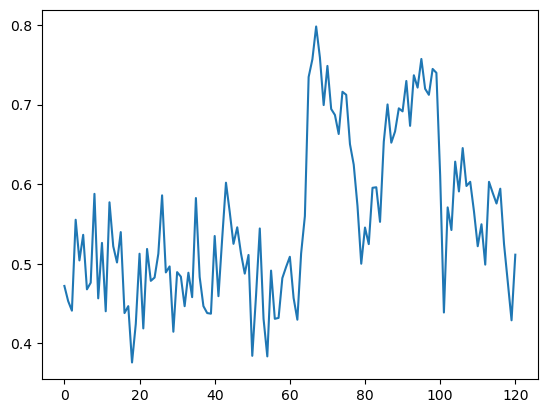

In [155]:
plt.plot(cv_scores_pre_250ms)

In [105]:
# Split attention types
epochs_endo = epochs_post_erp['attention_type_block==1'].copy()
epochs_endo = epochs_post_erp['attention_type_block==0'].copy()

In [106]:
# Data and class to predict
X = epochs_endo.copy().get_data(copy=False)
y = epochs_endo.metadata['cued_side']

#Model fitting adapted from https://mne.tools/stable/auto_tutorials/machine-learning/50_decoding.html#sphx-glr-auto-tutorials-machine-learning-50-decoding-py
clf_endo = make_pipeline(StandardScaler(), LogisticRegression(solver="liblinear"))

time_decod_endo = SlidingEstimator(clf_endo, n_jobs=5, scoring="roc_auc", verbose=True)
scores_endo = cross_val_multiscore(time_decod_endo, X, y, cv=5, n_jobs=5)

# Mean scores across cross-validation splits
scores_endo = np.mean(scores_endo, axis=0)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
 23%|██▎       | Fitting SlidingEstimator : 25/110 [00:00<00:00,  357.05it/s]
  0%|          | Fitting SlidingEstimator : 0/110 [00:00<?,       ?it/s]

 35%|███▌      | Fitting SlidingEstimator : 39/110 [00:00<00:00,  372.03it/s]A
  7%|▋         | Fitting SlidingEstimator : 8/110 [00:00<00:00,  225.23it/s]

 48%|████▊     | Fitting SlidingEstimator : 53/110 [00:00<00:00,  379.41it/s][A
 18%|█▊        | Fitting SlidingEstimator : 20/110 [00:00<00:00,  286.79it/s]

 59%|█████▉    | Fitting SlidingEstimator : 65/110 [00:00<00:00,  374.29it/s]
 27%|██▋       | Fitting SlidingEstimator : 30/110 [00:00<00:00,  287.63it/s]


  0%|          | Fitting SlidingEstimator : 0/110 [00:00<?,       ?it/s]

 69%|██████▉   | Fitting SlidingEstimator : 76/110 [00:00<00:00,  361.91it/s]
 39%|███▉      | Fitting SlidingEstimator : 43/110 [00:00<00:00,  308.47it/s]


  5%|▍         | Fitting SlidingEstimator : 5/110 [00:00<00:00,  14

In [139]:
# Data and class to predict
X = epochs_endo.get_data(copy=False)
y = epochs_endo.metadata['cued_side']

#Model fitting adapted from https://mne.tools/stable/auto_tutorials/machine-learning/50_decoding.html#sphx-glr-auto-tutorials-machine-learning-50-decoding-py
clf_endo = make_pipeline(StandardScaler(), LogisticRegression(solver="liblinear"))

time_decod_endo = SlidingEstimator(clf_endo, n_jobs=5, scoring="roc_auc", verbose=True)
scores_endo = cross_val_multiscore(time_decod_endo, X, y, cv=5, n_jobs=5)

# Mean scores across cross-validation splits
scores_endo = np.mean(scores_endo, axis=0)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
 20%|█▉        | Fitting SlidingEstimator : 39/200 [00:00<00:00,  373.24it/s]
 26%|██▌       | Fitting SlidingEstimator : 52/200 [00:00<00:00,  368.69it/s]
 33%|███▎      | Fitting SlidingEstimator : 66/200 [00:00<00:00,  376.02it/s][A
 44%|████▍     | Fitting SlidingEstimator : 89/200 [00:00<00:00,  362.79it/s]
 16%|█▋        | Fitting SlidingEstimator : 33/200 [00:00<00:00,  301.09it/s]

  0%|          | Fitting SlidingEstimator : 0/200 [00:00<?,       ?it/s]


 50%|█████     | Fitting SlidingEstimator : 101/200 [00:00<00:00,  360.10it/s]
 22%|██▏       | Fitting SlidingEstimator : 43/200 [00:00<00:00,  298.72it/s]

  2%|▎         | Fitting SlidingEstimator : 5/200 [00:00<00:01,  145.17it/s]


  3%|▎         | Fitting SlidingEstimator : 6/200 [00:00<00:01,  174.96it/s]
 56%|█████▌    | Fitting SlidingEstimator : 112/200 [00:00<00:00,  349.55it/s][A

  7%|▋         | Fitting SlidingEstimator : 14/200 [00:00<00:

In [140]:
time_decod_endo.

<SlidingEstimator({'allow_2d': False,
 'base_estimator': Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(solver='liblinear'))]),
 'n_jobs': 5,
 'position': 0,
 'scoring': 'roc_auc',
 'verbose': True})>

Text(0.5, 1.0, 'Sensor space decoding')

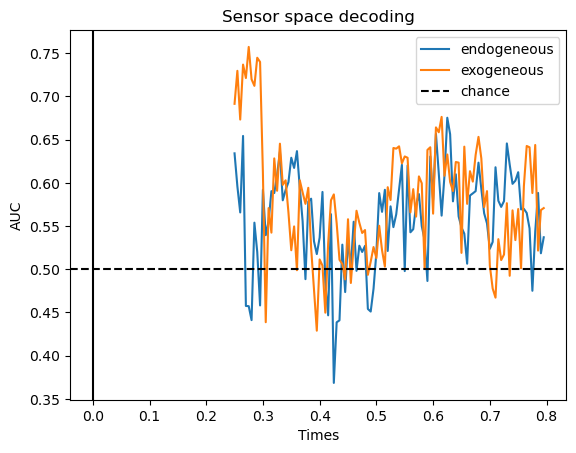

In [108]:
# Plot
fig, ax = plt.subplots()
tmin = epochs_post_erp.time_as_index(.25)[0]
tmax = epochs_post_erp.time_as_index(.8)[0]
ax.plot(epochs_post_erp.times[tmin:tmax], scores_endo[tmin:tmax], label="endogeneous")
ax.plot(epochs_post_erp.times[tmin:tmax], scores_endo[tmin:tmax], label="endogeneous")

ax.axhline(0.5, color="k", linestyle="--", label="chance")
ax.set_xlabel("Times")
ax.set_ylabel("AUC")
ax.legend()
ax.axvline(0.0, color="k", linestyle="-")
ax.set_title("Sensor space decoding")

In [52]:
np.save('files/B1_decoding.npy', np.vstack([scores_endo, scores_endo]))
np.save('files/decoding_times.npy', epochs.times)

In [110]:
time_gen = GeneralizingEstimator(clf_endo, scoring="roc_auc", n_jobs=None, verbose=True)

# Fit classifiers on the epochs with endogenous attention
epochs_endo = epochs_post_erp['attention_type_block==0'].copy()
time_gen.fit(X=epochs_endo.get_data(copy=False), y=epochs_endo.metadata['cued_side'])
epochs_endo = epochs['attention_type_block==0'].copy()
scores = time_gen.score(X=epochs_endo.get_data(copy=False), y=epochs_endo.metadata['cued_side'])

  0%|          | Fitting GeneralizingEstimator : 0/110 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/22000 [00:00<?,       ?it/s]

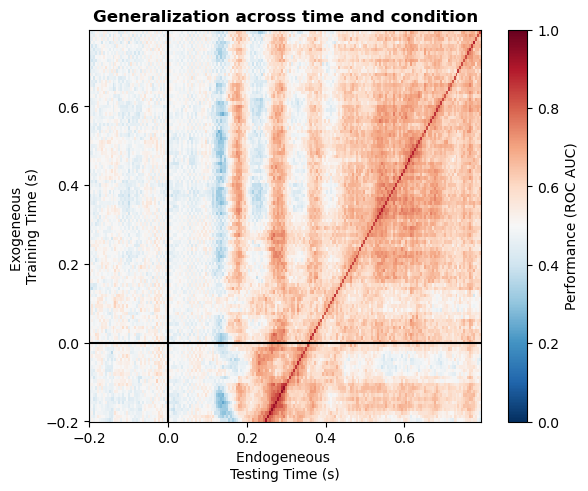

In [111]:
fig, ax = plt.subplots(layout="constrained")
im = ax.matshow(
    scores,
    vmin=0,
    vmax=1.0,
    cmap="RdBu_r",
    origin="lower",
    extent=epochs.times[[0, -1, 0, -1]],
)
ax.axhline(0.0, color="k")
ax.axvline(0.0, color="k")
ax.xaxis.set_ticks_position("bottom")
ax.set_xlabel(
    'Endogeneous \nTesting Time (s)',
)
ax.set_ylabel('endogeneous \nTraining Time (s)')
ax.set_title("Generalization across time and condition", fontweight="bold")
fig.colorbar(im, ax=ax, label="Performance (ROC AUC)")
plt.show()


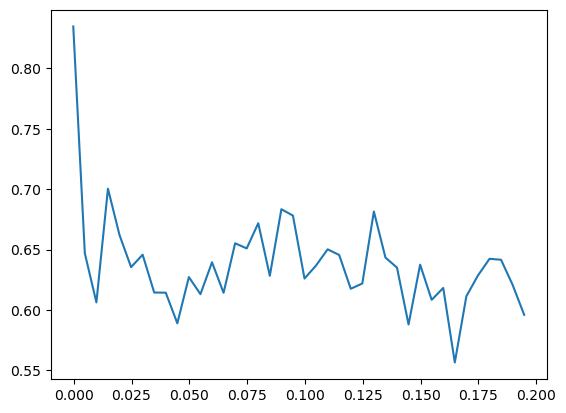

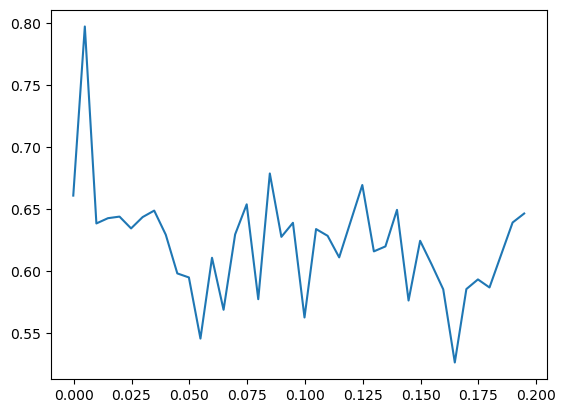

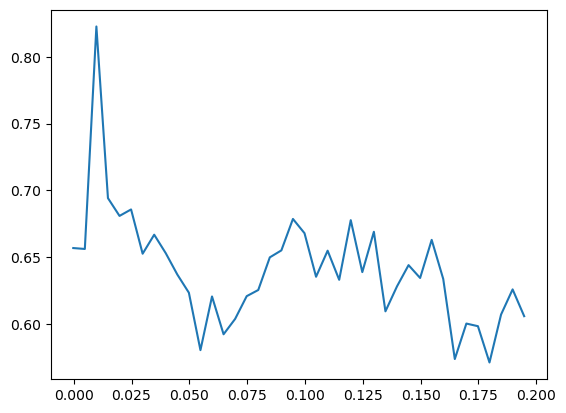

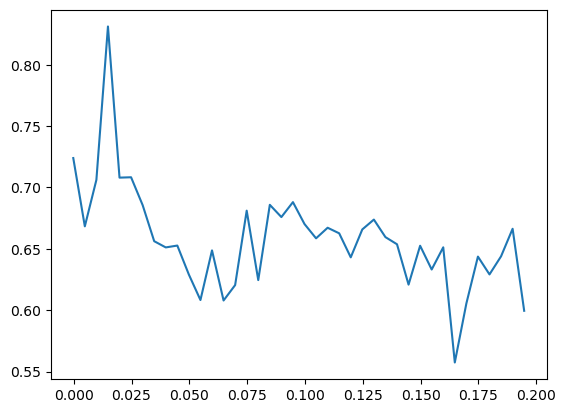

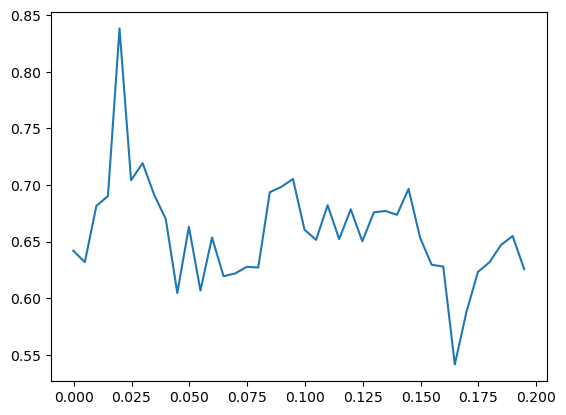

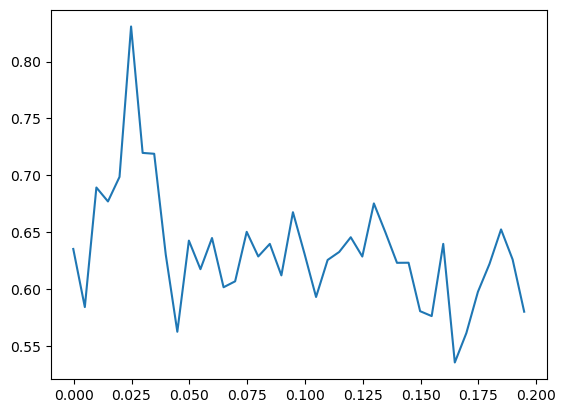

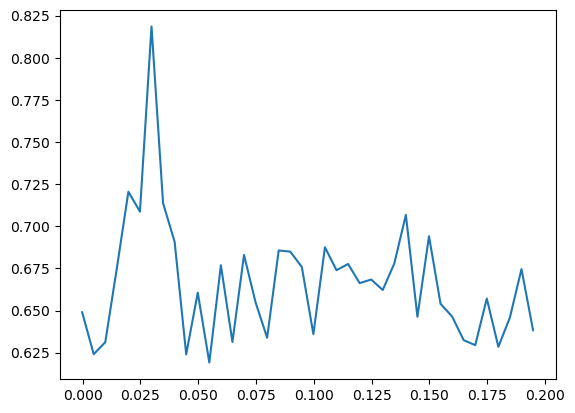

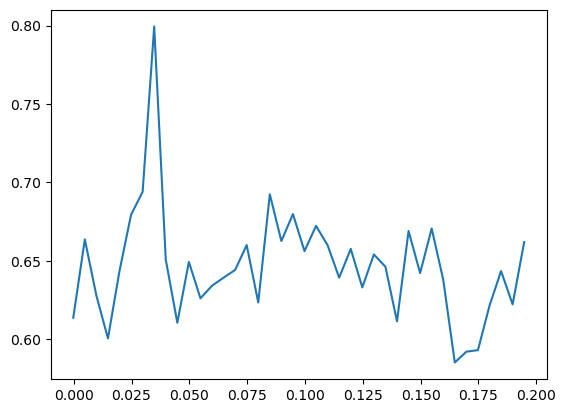

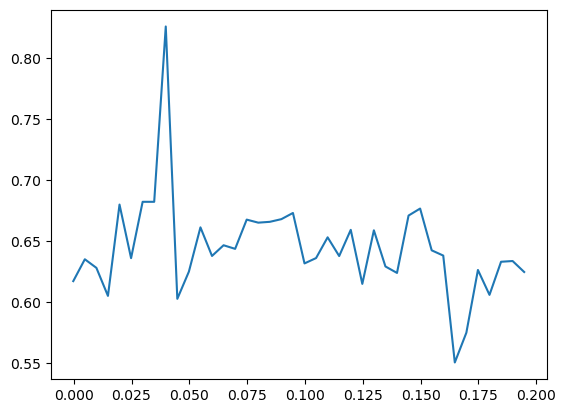

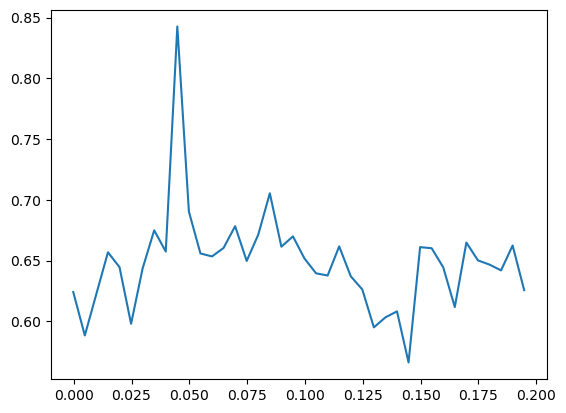

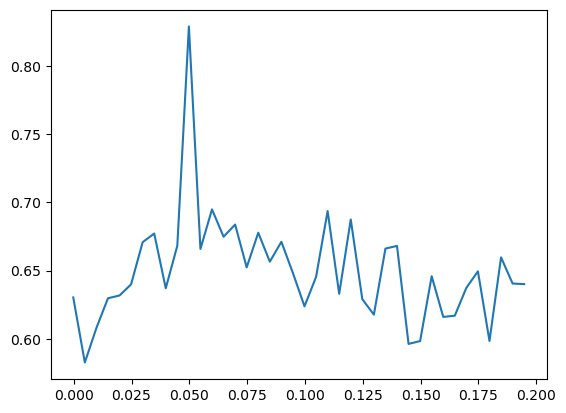

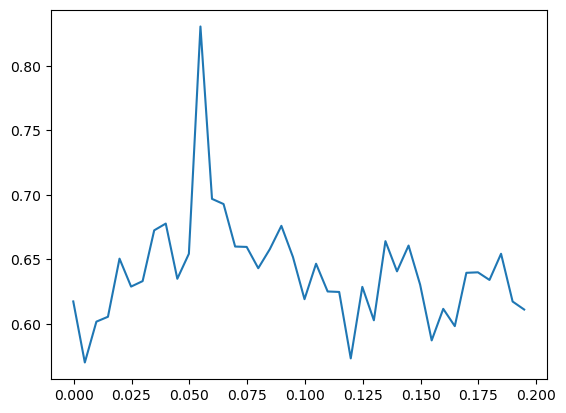

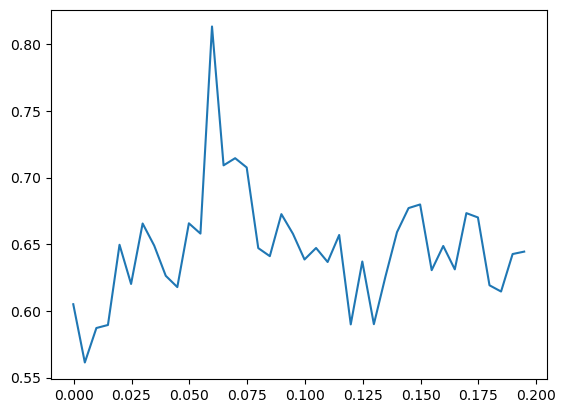

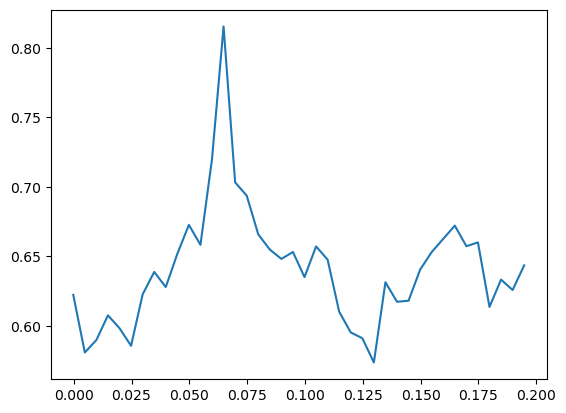

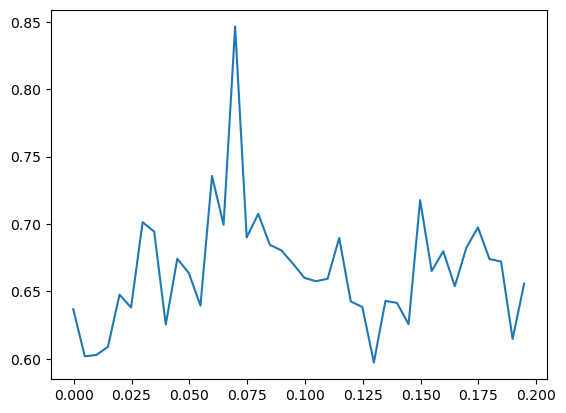

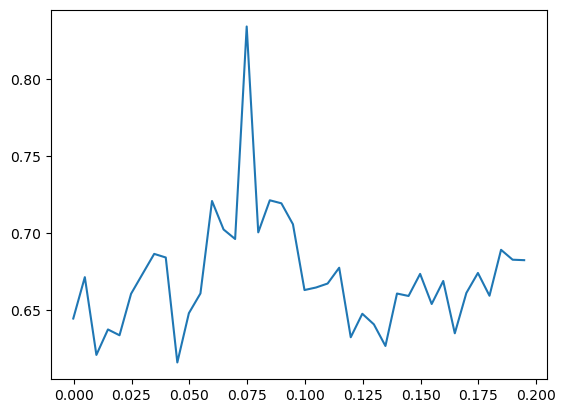

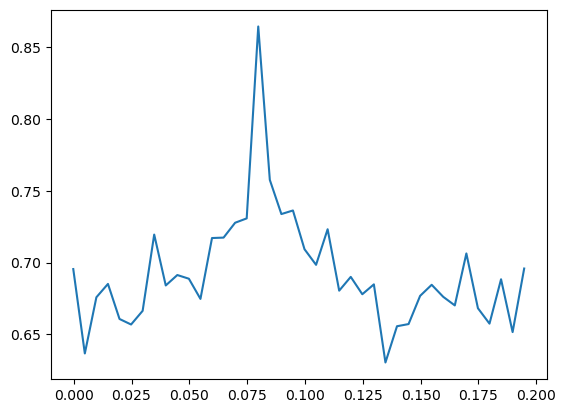

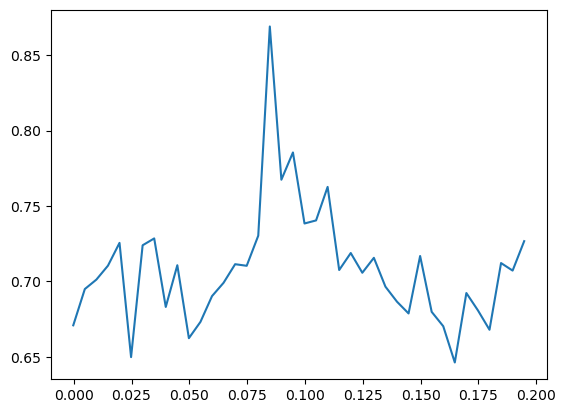

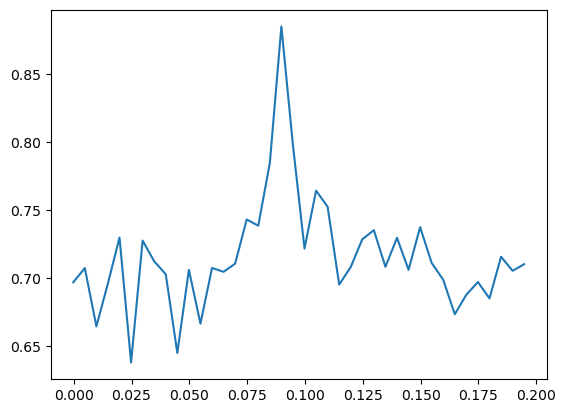

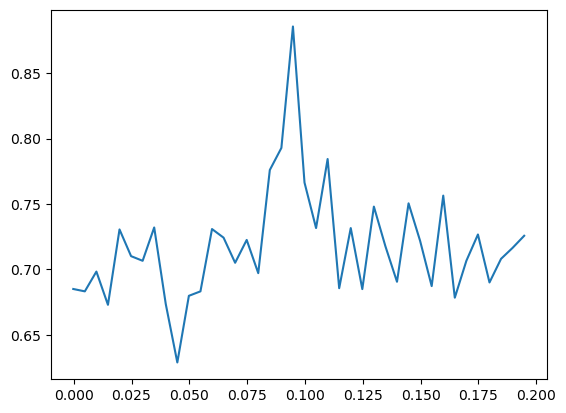

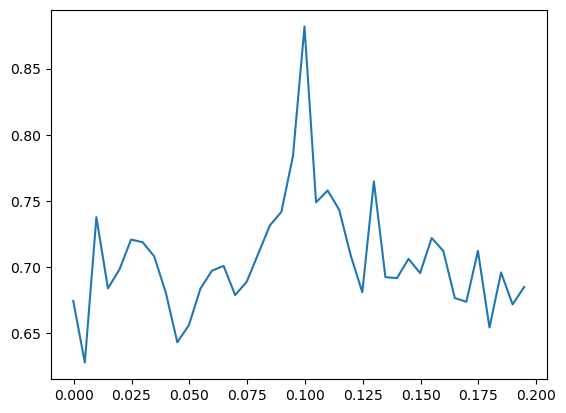

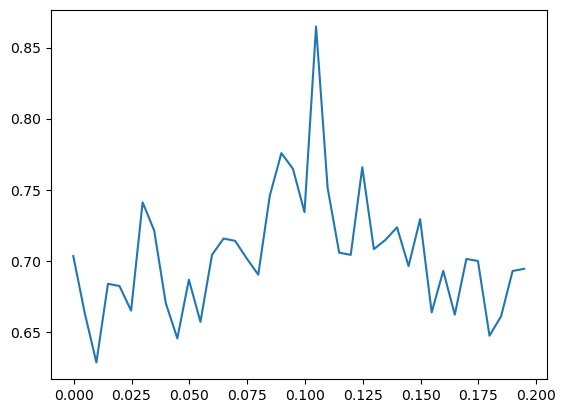

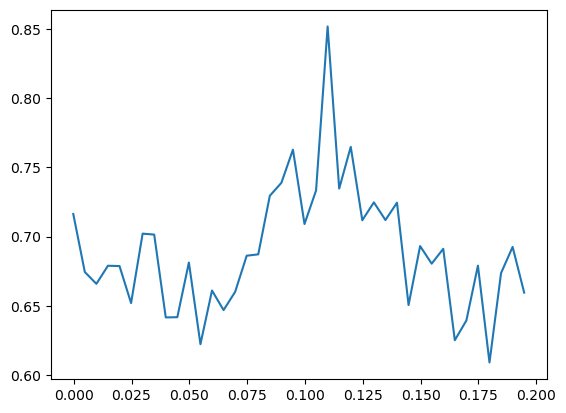

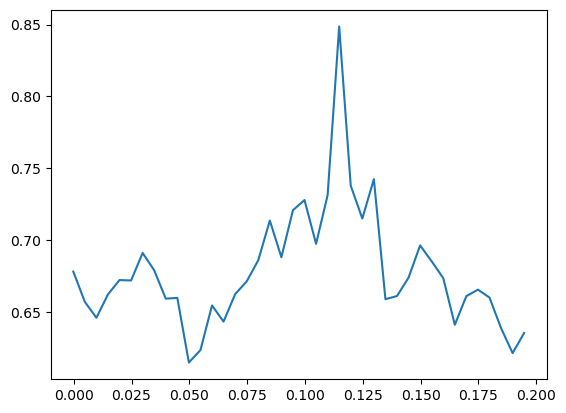

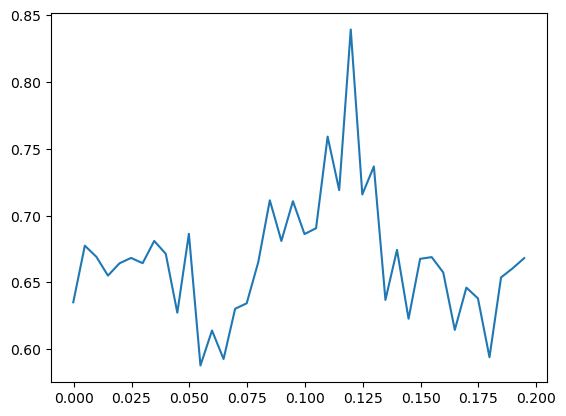

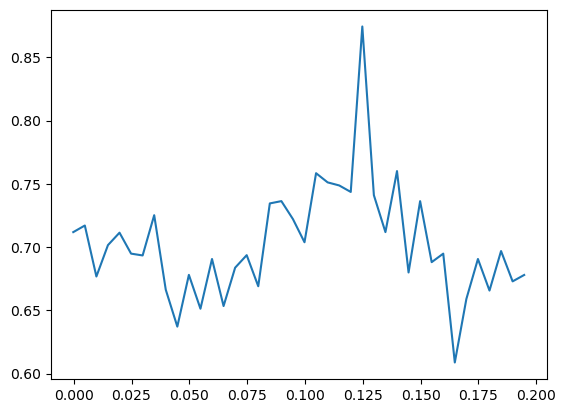

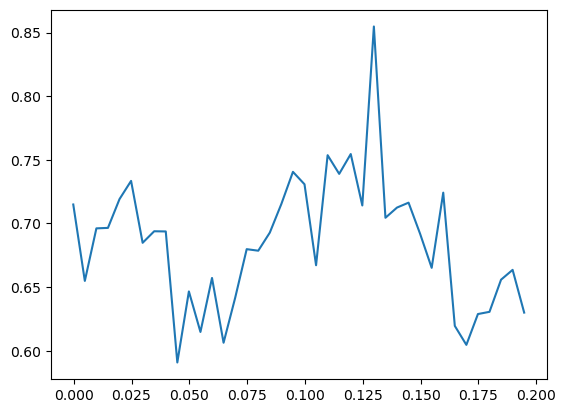

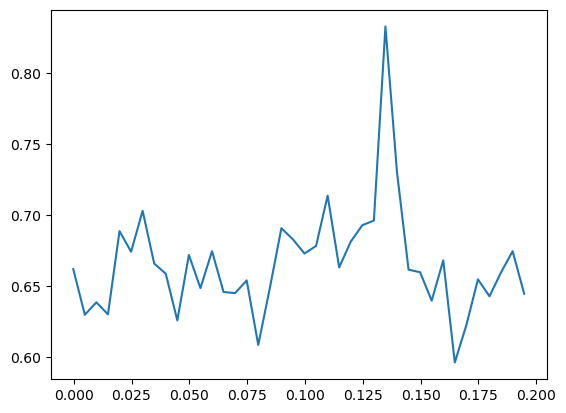

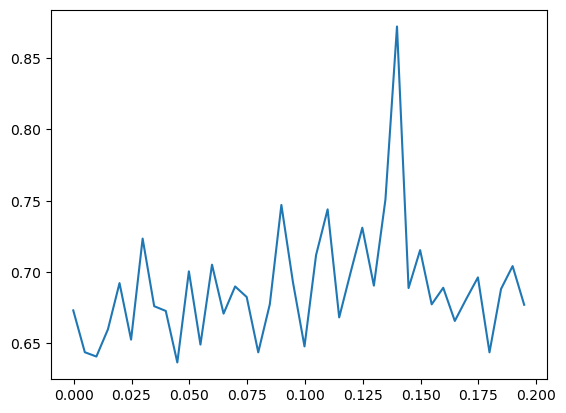

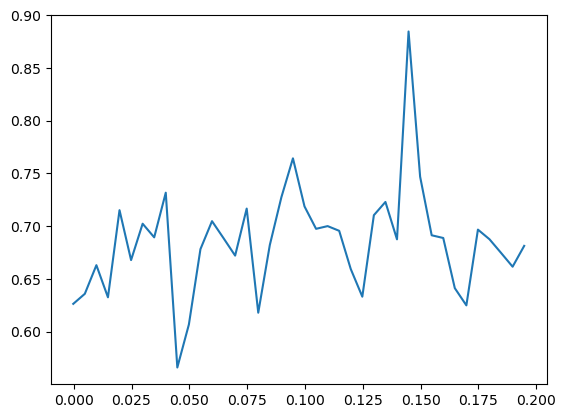

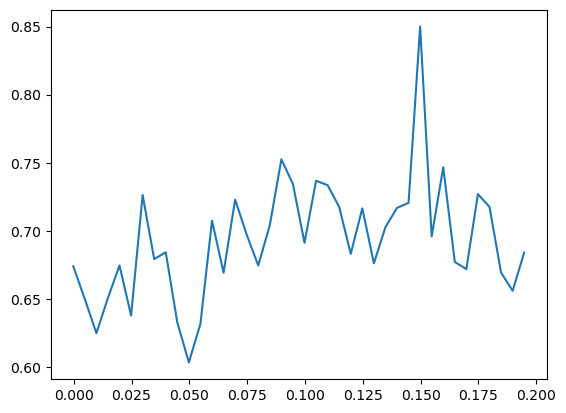

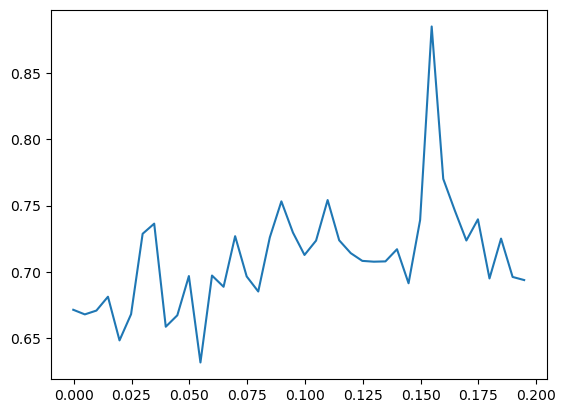

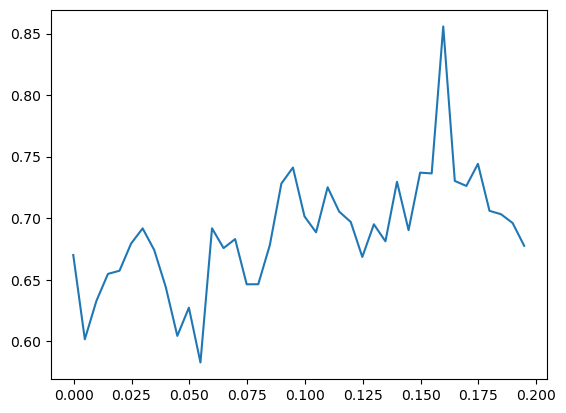

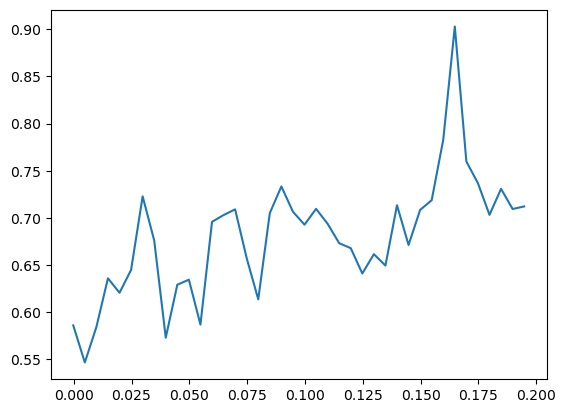

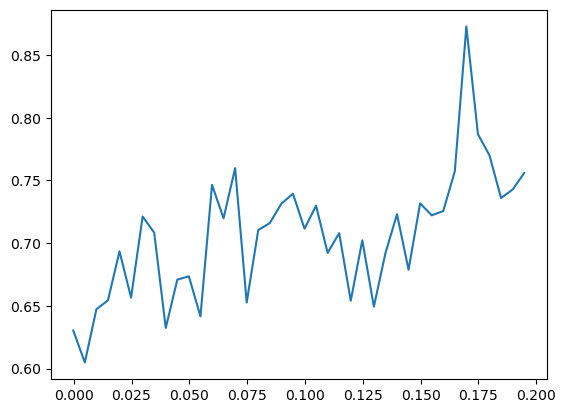

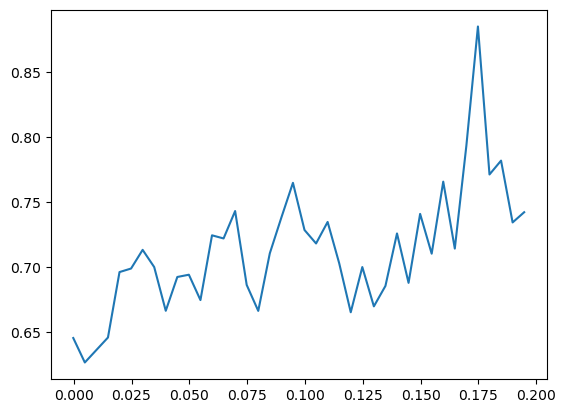

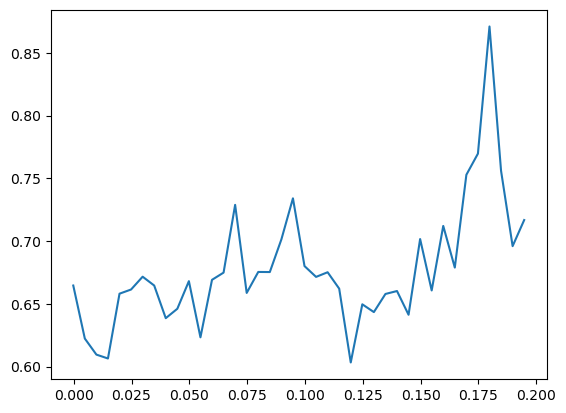

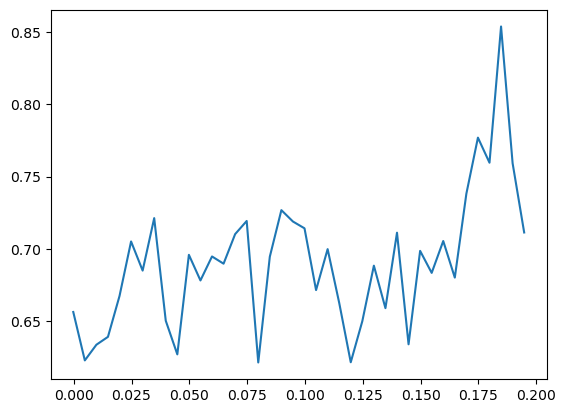

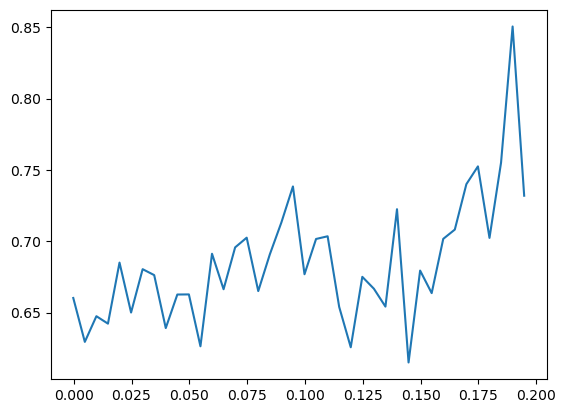

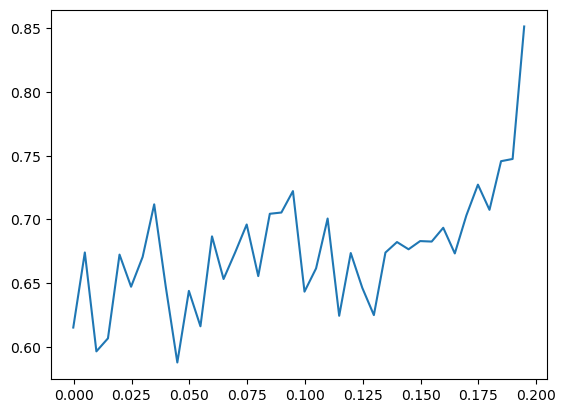

In [138]:
tmin = epochs.time_as_index(0)[0]
tmax = epochs.time_as_index(.2)[0]
for index in np.argmax(scores[tmin:tmax,:], axis=-1):
    plt.plot(epochs.times[tmin: tmax], scores[tmin:tmax,index])
    plt.show()



In [29]:
time_gen = GeneralizingEstimator(clf_endo, scoring="roc_auc", n_jobs=None, verbose=True)

# Fit classifiers on the epochs with endogeneous attention
time_gen.fit(X=epochs_endo.get_data(copy=False), y=epochs_endo.metadata['cued_side'])
scores = time_gen.score(X=epochs_endo.get_data(copy=False), y=epochs_endo.metadata['cued_side'])

  0%|          | Fitting GeneralizingEstimator : 0/200 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/40000 [00:00<?,       ?it/s]

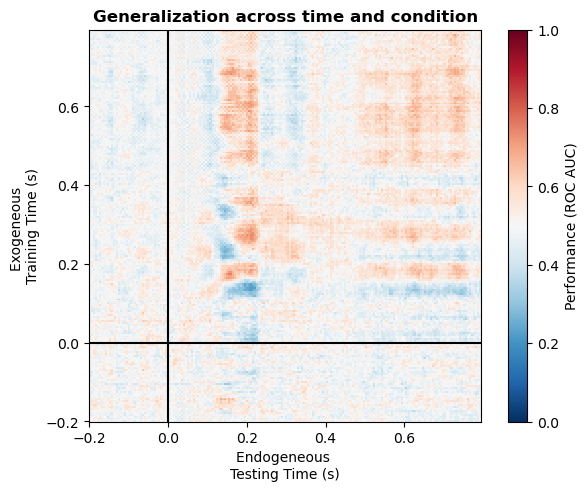

In [30]:
fig, ax = plt.subplots(layout="constrained")
im = ax.matshow(
    scores,
    vmin=0,
    vmax=1.0,
    cmap="RdBu_r",
    origin="lower",
    extent=epochs.times[[0, -1, 0, -1]],
)
ax.axhline(0.0, color="k")
ax.axvline(0.0, color="k")
ax.xaxis.set_ticks_position("bottom")
ax.set_xlabel(
    'Endogeneous \nTesting Time (s)',
)
ax.set_ylabel('endogeneous \nTraining Time (s)')
ax.set_title("Generalization across time and condition", fontweight="bold")
fig.colorbar(im, ax=ax, label="Performance (ROC AUC)")
plt.show()


In [10]:
# n_cylce: trade-off temporal vs frequency resolution (is how many cycles of the frequency to include in the Gaussian envelope). 
# Frequency resolution is emphasized.

# time window from -1 sec to 1 sec relative to cue
tmin, tmax = -1, 1
# Define range of frequencies of interest
freqs = np.arange(55, 75, step = 0.5)

itc_endo = epochs_endo.compute_tfr(
    method="morlet", freqs=freqs, n_cycles=freqs/2,return_itc=False, average=False
)
itc_endo = epochs_endo.compute_tfr(
    method="morlet", freqs=freqs, n_cycles=freqs/2,return_itc=False, average=False
)

# # Baseline (-1 to 0s) correction
# itc_endo = itc_endo.apply_baseline(baseline=(tmin, 0))
# itc_endo = itc_endo.apply_baseline(baseline=(tmin, 0))

# fig, axes = plt.subplots(3, 6, figsize=(18, 9), sharey = True) 
# axes = axes.flatten() 

# channels = epochs.info['ch_names']

# # Plot each electrode
# for e, (channel, ax) in enumerate(zip(channels, axes)):
#     itc_endo.plot(
#         picks=[channel],
#         baseline=None,
#         vlim=(-.4, .4),
#         axes=ax,
#         colorbar=False,
#         show=False 
#     )
#     ax.set_title(channel) 
#     ax.axhline(y=60, color='r', linestyle='--', linewidth=1)
#     ax.axhline(y=64, color='r', linestyle='--', linewidth=1)
    
# plt.tight_layout()
# plt.show()
# fig, axes = plt.subplots(3, 6, figsize=(18, 9), sharey = True) 
# axes = axes.flatten() 

# channels = epochs.info['ch_names']

# # Plot each electrode
# for e, (channel, ax) in enumerate(zip(channels, axes)):
#     itc_endo.plot(
#         picks=[channel],
#         baseline=None,
#         vlim=(-.4, .4),
#         axes=ax,
#         colorbar=False,
#         show=False 
#     )
#     ax.set_title(channel) 
#     ax.axhline(y=60, color='r', linestyle='--', linewidth=1)
#     ax.axhline(y=64, color='r', linestyle='--', linewidth=1)
    
# plt.tight_layout()
# plt.show()

ValueError: freqs must be an array-like, got <class 'int'> instead.

In [ ]:
X.shape

In [11]:
# Data and class to predict
X = itc_endo.get_data()
y = epochs_endo.metadata['cued_side']

#Model fitting adapted from https://mne.tools/stable/auto_tutorials/machine-learning/50_decoding.html#sphx-glr-auto-tutorials-machine-learning-50-decoding-py
clf_endo = make_pipeline(StandardScaler(), LogisticRegression(solver="liblinear"))

time_decod_endo = SlidingEstimator(clf_endo, n_jobs=5, scoring="roc_auc", verbose=True)
scores_endo = cross_val_multiscore(time_decod_endo, X, y, cv=5, n_jobs=5)

# Mean scores across cross-validation splits
scores_endo = np.mean(scores_endo, axis=0)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
  0%|          | Fitting SlidingEstimator : 0/240 [00:00<?,       ?it/s]


ValueError: Found array with dim 3. StandardScaler expected <= 2.

In [ ]:
# Data and class to predict
X = itc_endo.get_data(copy=False)
y = epochs_endo.metadata['cued_side']

#Model fitting adapted from https://mne.tools/stable/auto_tutorials/machine-learning/50_decoding.html#sphx-glr-auto-tutorials-machine-learning-50-decoding-py
clf_endo = make_pipeline(StandardScaler(), LogisticRegression(solver="liblinear"))

time_decod_endo = SlidingEstimator(clf_endo, n_jobs=5, scoring="roc_auc", verbose=True)
scores_endo = cross_val_multiscore(time_decod_endo, X, y, cv=5, n_jobs=5)

# Mean scores across cross-validation splits
scores_endo = np.mean(scores_endo, axis=0)

In [ ]:
# Plot
fig, ax = plt.subplots()
tmin = epochs.time_as_index(-.1)[0]
tmax = epochs.time_as_index(.8)[0]
ax.plot(epochs.times[tmin:tmax], scores_endo[tmin:tmax], label="endogeneous")
ax.plot(epochs.times[tmin:tmax], scores_endo[tmin:tmax], label="endogeneous")

ax.axhline(0.5, color="k", linestyle="--", label="chance")
ax.set_xlabel("Times")
ax.set_ylabel("AUC")
ax.legend()
ax.axvline(0.0, color="k", linestyle="-")
ax.set_title("Sensor space decoding")

In [12]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder

from mne import Epochs, create_info
from mne.datasets import eegbci
from mne.decoding import CSP
from mne.io import concatenate_raws, read_raw_edf
from mne.time_frequency import AverageTFRArray

In [72]:
window_spacing

0.07142857142857142

In [85]:
# Extract information from the raw file
sfreq = epochs.info["sfreq"]
epochs.pick(picks="eeg", exclude="bads")
epochs.load_data()

# Assemble the classifier using scikit-learn pipeline
clf = make_pipeline(
    CSP(n_components=10, reg=None, log=True, norm_trace=False),
    LinearDiscriminantAnalysis(),
)
n_splits = 3  # for cross-validation, 5 is better, here we use 3 for speed
cv = StratifiedKFold(n_splits=n_splits, shuffle=True)

# Classification & time-frequency parameters
tmin, tmax = -0.200, 2.000
n_cycles = 10.0  # how many complete cycles: used to define window size
min_freq = 59
max_freq = 65
n_freqs = 15  # how many frequency bins to use

# Assemble list of frequency range tuples
freqs = np.linspace(min_freq, max_freq, n_freqs)  # assemble frequencies
freq_ranges = list(zip(freqs[:-1], freqs[1:]))  # make freqs list of tuples

# Infer window spacing from the max freq and number of cycles to avoid gaps
window_spacing = n_cycles / np.max(freqs) / 2.0
centered_w_times = np.arange(tmin, tmax, window_spacing)[1:]
n_windows = len(centered_w_times)

# Instantiate label encoder
le = LabelEncoder()

In [86]:
# init scores
freq_scores = np.zeros((n_freqs - 1,))

# Loop through each frequency range of interest
for freq, (fmin, fmax) in enumerate(freq_ranges):
    # Infer window size based on the frequency being used
    w_size = n_cycles / ((fmax + fmin) / 2.0)  # in seconds

    # Apply band-pass filter to isolate the specified frequencies
    epoch_filter = epochs.copy().filter(
        fmin, fmax, fir_design="firwin", skip_by_annotation="edge"
    )


    y = le.fit_transform(epoch_filter.metadata['cued_side'])

    X = epoch_filter.get_data(copy=False)

    # Save mean scores over folds for each frequency and time window
    freq_scores[freq] = np.mean(
        cross_val_score(estimator=clf, X=X, y=y, scoring="roc_auc", cv=cv), axis=0
    )

Setting up band-pass filter from 59 - 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.00
- Lower transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 51.62 Hz)
- Upper passband edge: 59.43 Hz
- Upper transition bandwidth: 14.86 Hz (-6 dB cutoff frequency: 66.86 Hz)
- Filter length: 45 samples (0.225 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 2177 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 2591 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 3041 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 3527 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 4607 tasks      | elapsed:    0.6s
[Parallel(n_job

Computing rank from data with rank=None
    Using tolerance 1.3e-05 (2.2e-16 eps * 64 dim * 9.2e+08  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.3e-05 (2.2e-16 eps * 64 dim * 9.2e+08  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.3e-05 (2.2e-16 eps * 64 dim * 9.2e+08  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=0 covariance using EMP

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 2177 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 2591 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 3041 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 3527 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 4607 tasks      | elapsed:    0.6s
[Parallel(n_job

Computing rank from data with rank=None
    Using tolerance 1.3e-05 (2.2e-16 eps * 64 dim * 9.3e+08  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.3e-05 (2.2e-16 eps * 64 dim * 9.3e+08  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.3e-05 (2.2e-16 eps * 64 dim * 9.3e+08  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=0 covariance using EMP

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 2177 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 2591 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 3041 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 3527 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 4607 tasks      | elapsed:    0.6s
[Parallel(n_job

Computing rank from data with rank=None


[Parallel(n_jobs=1)]: Done 28799 tasks      | elapsed:    3.7s


    Using tolerance 1.3e-05 (2.2e-16 eps * 64 dim * 9.3e+08  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.3e-05 (2.2e-16 eps * 64 dim * 9.2e+08  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.3e-05 (2.2e-16 eps * 64 dim * 9.3e+08  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covarian

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 2177 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 2591 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 3041 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 3527 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 4607 tasks      | elapsed:    0.7s
[Parallel(n_job

Computing rank from data with rank=None


[Parallel(n_jobs=1)]: Done 28799 tasks      | elapsed:    3.7s


    Using tolerance 1.3e-05 (2.2e-16 eps * 64 dim * 9.4e+08  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.3e-05 (2.2e-16 eps * 64 dim * 9.3e+08  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.3e-05 (2.2e-16 eps * 64 dim * 9.3e+08  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covarian

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 2177 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 2591 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 3041 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 3527 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 4607 tasks      | elapsed:    0.6s
[Parallel(n_job

Computing rank from data with rank=None
    Using tolerance 1.3e-05 (2.2e-16 eps * 64 dim * 9.4e+08  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.3e-05 (2.2e-16 eps * 64 dim * 9.3e+08  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.3e-05 (2.2e-16 eps * 64 dim * 9.3e+08  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=0 covariance using EMP

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 2177 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 2591 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 3041 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 3527 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 4607 tasks      | elapsed:    0.7s
[Parallel(n_job

Computing rank from data with rank=None


[Parallel(n_jobs=1)]: Done 28799 tasks      | elapsed:    3.8s


    Using tolerance 1.3e-05 (2.2e-16 eps * 64 dim * 9.4e+08  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.3e-05 (2.2e-16 eps * 64 dim * 9.4e+08  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.3e-05 (2.2e-16 eps * 64 dim * 9.3e+08  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covarian

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 2177 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 2591 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 3041 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 3527 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 4607 tasks      | elapsed:    0.6s
[Parallel(n_job

Computing rank from data with rank=None


[Parallel(n_jobs=1)]: Done 28799 tasks      | elapsed:    3.8s


    Using tolerance 1.3e-05 (2.2e-16 eps * 64 dim * 9.4e+08  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.3e-05 (2.2e-16 eps * 64 dim * 9.5e+08  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.3e-05 (2.2e-16 eps * 64 dim * 9.3e+08  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covarian

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 2177 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 2591 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 3041 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 3527 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 4607 tasks      | elapsed:    0.7s
[Parallel(n_job

Computing rank from data with rank=None


[Parallel(n_jobs=1)]: Done 28799 tasks      | elapsed:    3.7s


    Using tolerance 1.3e-05 (2.2e-16 eps * 64 dim * 9.4e+08  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.3e-05 (2.2e-16 eps * 64 dim * 9.4e+08  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.4e-05 (2.2e-16 eps * 64 dim * 9.5e+08  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covarian

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 2177 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 2591 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 3041 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 3527 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 4607 tasks      | elapsed:    0.6s
[Parallel(n_job

Computing rank from data with rank=None


[Parallel(n_jobs=1)]: Done 28799 tasks      | elapsed:    3.8s


    Using tolerance 1.4e-05 (2.2e-16 eps * 64 dim * 9.6e+08  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.4e-05 (2.2e-16 eps * 64 dim * 9.5e+08  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.3e-05 (2.2e-16 eps * 64 dim * 9.4e+08  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covarian

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 2177 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 2591 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 3041 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 3527 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 4607 tasks      | elapsed:    0.6s
[Parallel(n_job

Computing rank from data with rank=None
    Using tolerance 1.4e-05 (2.2e-16 eps * 64 dim * 9.5e+08  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.4e-05 (2.2e-16 eps * 64 dim * 9.5e+08  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.4e-05 (2.2e-16 eps * 64 dim * 9.6e+08  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=0 covariance using EMP

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 2177 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 2591 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 3041 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 3527 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 4607 tasks      | elapsed:    0.7s
[Parallel(n_job

Computing rank from data with rank=None


[Parallel(n_jobs=1)]: Done 28799 tasks      | elapsed:    3.8s


    Using tolerance 1.4e-05 (2.2e-16 eps * 64 dim * 9.6e+08  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.4e-05 (2.2e-16 eps * 64 dim * 9.6e+08  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.3e-05 (2.2e-16 eps * 64 dim * 9.5e+08  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covarian

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 2177 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 2591 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 3041 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 3527 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 4607 tasks      | elapsed:    0.6s
[Parallel(n_job

Computing rank from data with rank=None
    Using tolerance 1.3e-05 (2.2e-16 eps * 64 dim * 9.4e+08  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.4e-05 (2.2e-16 eps * 64 dim * 9.6e+08  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.4e-05 (2.2e-16 eps * 64 dim * 9.7e+08  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=0 covariance using EMP

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 2177 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 2591 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 3041 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 3527 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 4607 tasks      | elapsed:    0.7s
[Parallel(n_job

Computing rank from data with rank=None


[Parallel(n_jobs=1)]: Done 28799 tasks      | elapsed:    3.9s


    Using tolerance 1.4e-05 (2.2e-16 eps * 64 dim * 9.5e+08  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.4e-05 (2.2e-16 eps * 64 dim * 9.6e+08  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.4e-05 (2.2e-16 eps * 64 dim * 9.7e+08  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covarian

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 2177 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 2591 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 3041 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 3527 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 4607 tasks      | elapsed:    0.6s
[Parallel(n_job

Computing rank from data with rank=None
    Using tolerance 1.4e-05 (2.2e-16 eps * 64 dim * 9.7e+08  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.4e-05 (2.2e-16 eps * 64 dim * 9.6e+08  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.4e-05 (2.2e-16 eps * 64 dim * 9.6e+08  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=0 covariance using EMP

Text(0.5, 1.0, 'Frequency Decoding Scores')

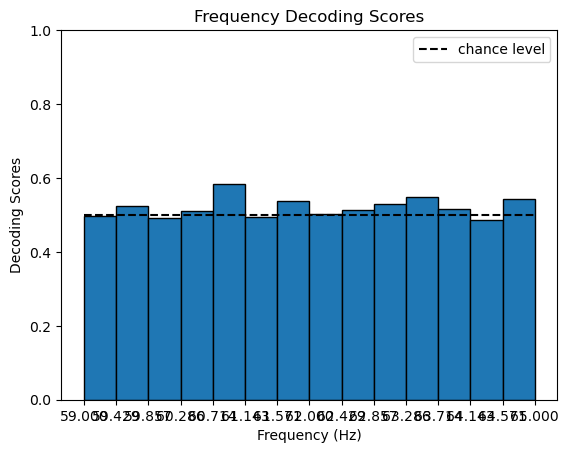

In [87]:
plt.bar(
    freqs[:-1], freq_scores, width=np.diff(freqs)[0], align="edge", edgecolor="black"
)
plt.xticks(freqs)
plt.ylim([0, 1])
plt.hlines(.5, 59,65, color="k", linestyle="--", label="chance level"
)
plt.legend()
plt.xlabel("Frequency (Hz)")
plt.ylabel("Decoding Scores")
plt.title("Frequency Decoding Scores")

In [66]:
X.shape

(64, 2)

In [69]:
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from mne.decoding import CSP
from mne.preprocessing import ICA
from mne.time_frequency import tfr_multitaper

# Extract information from the raw file
sfreq = epochs.info["sfreq"]
epochs.pick(picks="eeg", exclude="bads")
epochs.load_data()

# Epoch selection: Focus on time window well after the cue to avoid ERP influence
tmin = 0.2  # Start time after the ERP (e.g., 200 ms post-cue)
tmax = 1.0  # End time

epochs = epochs.crop(tmin=tmin, tmax=tmax)

# Frequency ranges of interest (narrow bands around 60 and 64 Hz)
freqs = [60, 64]
n_cycles = 5  # Number of cycles in wavelet

# Time-frequency decomposition using multitaper method
power = tfr_multitaper(epochs, freqs=freqs, n_cycles=n_cycles, time_bandwidth=4.0, return_itc=False)

# Extract the power in the specified frequency bands
X = power.data[:, :, :].mean(axis=2)  # Average power over the selected time window

# Labels
y = epochs.metadata['cued_side']
le = LabelEncoder()
y = le.fit_transform(y)

# Classifier and cross-validation
clf = make_pipeline(
    StandardScaler(),
    LinearDiscriminantAnalysis()
)

param_grid = {
    'lda__solver': ['svd', 'lsqr', 'eigen']
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Grid search for hyperparameter tuning
grid_search = GridSearchCV(clf, param_grid, cv=cv, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X, y)
best_clf = grid_search.best_estimator_

# Evaluate the best model using cross-validation
scores = cross_val_score(estimator=best_clf, X=X, y=y, scoring="roc_auc", cv=cv)

# Output scores
print("ROC AUC scores:", scores)
print("Mean ROC AUC score:", np.mean(scores))


NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").


/tmp/ipykernel_87041/3842208024.py:19: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.epochs.EpochsFIF'>.tmax (0.994805 s)
  epochs = epochs.crop(tmin=tmin, tmax=tmax)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.7s


ValueError: Found input variables with inconsistent numbers of samples: [64, 462]

In [70]:
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from mne.decoding import CSP
from mne.preprocessing import ICA
from mne.time_frequency import tfr_multitaper

# Extract information from the raw file
sfreq = epochs.info["sfreq"]
epochs.pick(picks="eeg", exclude="bads")
epochs.load_data()

# Epoch selection: Focus on time window well after the cue to avoid ERP influence
tmin = 0.2  # Start time after the ERP (e.g., 200 ms post-cue)
tmax = 1.0  # End time

epochs = epochs.crop(tmin=tmin, tmax=tmax)

# Frequency ranges of interest (narrow bands around 60 and 64 Hz)
freqs = [60, 64]
n_cycles = 5  # Number of cycles in wavelet

# Time-frequency decomposition using multitaper method
power = tfr_multitaper(epochs, freqs=freqs, n_cycles=n_cycles, time_bandwidth=4.0, return_itc=False)

# Extract the power in the specified frequency bands
X = power.data[:, :, :].mean(axis=2)  # Average power over the selected time window

# Labels
y = epochs.metadata['cued_side']
le = LabelEncoder()
y = le.fit_transform(y)

# Ensure X and y have consistent samples
assert X.shape[0] == len(y), "Mismatch in number of samples between X and y"

# Classifier and cross-validation
clf = make_pipeline(
    StandardScaler(),
    LinearDiscriminantAnalysis()
)

param_grid = {
    'lda__solver': ['svd', 'lsqr', 'eigen']
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Grid search for hyperparameter tuning
grid_search = GridSearchCV(clf, param_grid, cv=cv, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X, y)
best_clf = grid_search.best_estimator_

# Evaluate the best model using cross-validation
scores = cross_val_score(estimator=best_clf, X=X, y=y, scoring="roc_auc", cv=cv)

# Output scores
print("ROC AUC scores:", scores)
print("Mean ROC AUC score:", np.mean(scores))


NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").


/tmp/ipykernel_87041/3493175261.py:19: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.epochs.EpochsFIF'>.tmax (0.994805 s)
  epochs = epochs.crop(tmin=tmin, tmax=tmax)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.6s


AssertionError: Mismatch in number of samples between X and y

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 1.0, 'Frequency Decoding Scores')

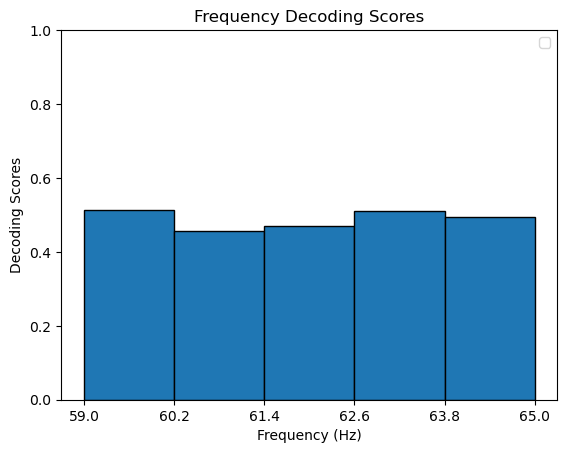

In [47]:
plt.bar(
    freqs[:-1], freq_scores, width=np.diff(freqs)[0], align="edge", edgecolor="black"
)
plt.xticks(freqs)
plt.ylim([0, 1])
# plt.axhline(
#     len(epochs["feet"]) / len(epochs), color="k", linestyle="--", label="chance level"
# )
plt.legend()
plt.xlabel("Frequency (Hz)")
plt.ylabel("Decoding Scores")
plt.title("Frequency Decoding Scores")

In [45]:
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from mne.decoding import CSP
from mne.preprocessing import ICA

# Extract information from the raw file
sfreq = epochs.info["sfreq"]
epochs.pick(picks="eeg", exclude="bads")
epochs.load_data()

# Frequency ranges of interest
min_freq = 59
max_freq = 65
n_freqs = 6  # number of frequency bins
freqs = np.linspace(min_freq, max_freq, n_freqs)
freq_ranges = list(zip(freqs[:-1], freqs[1:]))

# Time-frequency parameters
tmin, tmax = -0.200, 1.000
n_cycles = 10.0
window_spacing = n_cycles / np.max(freqs) / 2.0
centered_w_times = np.arange(tmin, tmax, window_spacing)[1:]
n_windows = len(centered_w_times)

# Instantiate label encoder
le = LabelEncoder()

# Initialize scores
freq_scores = np.zeros((n_freqs - 1,))

# Classifier and cross-validation
clf = make_pipeline(
    CSP(n_components=None, reg=None, log=True, norm_trace=False),
    StandardScaler(),
    LinearDiscriminantAnalysis()
)
param_grid = {
    'csp__n_components': [4, 6, 8, 10],
    'csp__reg': [None, 0.1, 0.2]
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Loop through each frequency range
for freq, (fmin, fmax) in enumerate(freq_ranges):
    # Infer window size based on the frequency being used
    w_size = n_cycles / ((fmax + fmin) / 2.0)  # in seconds

    # Apply band-pass filter to isolate the specified frequencies
    epoch_filter = epochs.copy().filter(fmin, fmax, fir_design="firwin", skip_by_annotation="edge")

    # Extract features and labels
    y = le.fit_transform(epoch_filter.metadata['cued_side'])
    X = epoch_filter.get_data(copy=True)

    # Nested cross-validation for hyperparameter tuning and model evaluation
    grid_search = GridSearchCV(clf, param_grid, cv=cv, scoring='roc_auc', n_jobs=-1)
    grid_search.fit(X, y)
    best_clf = grid_search.best_estimator_

    # Evaluate the best model using cross-validation
    freq_scores[freq] = np.mean(cross_val_score(estimator=best_clf, X=X, y=y, scoring="roc_auc", cv=cv), axis=0)

# Output frequency scores
print(freq_scores)


ValueError: n_components must be an integer.